In [1]:
import time
import glob
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import ipywidgets as pyw
import tkinter.filedialog as tkf
import tifffile
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import linalg as LA
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
def zero_one_rescale(spectrum):
    """
    normalize one spectrum from 0.0 to 1.0
    """
    spectrum = spectrum.clip(min=0.0)
    min_val = np.min(spectrum)
    
    rescaled = spectrum - min_val
    
    if np.max(rescaled) != 0:
        rescaled = rescaled / np.max(rescaled)
    
    return rescaled

def reshape_coeff(coeffs, new_shape):
    """
    reshape a coefficient matrix to restore the original scanning shapes.
    """
    coeff_reshape = []
    for i in range(len(new_shape)):
        temp = coeffs[:int(new_shape[i, 0]*new_shape[i, 1]), :]
        coeffs = np.delete(coeffs, range(int(new_shape[i, 0]*new_shape[i, 1])), axis=0)
        temp = np.reshape(temp, (new_shape[i, 0], new_shape[i, 1], -1))
        #print(temp.shape)
        coeff_reshape.append(temp)
        
    return coeff_reshape

def indices_at_r(shape, radius, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    
    ri = np.where(r == radius)
    
    angle_arr = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            angle_arr[i, j] = np.angle(complex(x[i, j]-center[1], y[i, j]-center[0]), deg=True)
            
    angle_arr = angle_arr + 180
    angle_arr = np.around(angle_arr)
    
    ai = np.argsort(angle_arr[ri])
    r_sort = (ri[1][ai], ri[0][ai])
    a_sort = np.sort(angle_arr[ri])
        
    return r_sort, a_sort

def circle_flatten(f_stack, radial_range, c_pos):
    k_indx = []
    k_indy = []
    
    for r in range(radial_range[0], radial_range[1], radial_range[2]):
        tmp_k, tmp_a = indices_at_r(f_stack.shape[2:], r, c_pos)
        k_indx.extend(tmp_k[0].tolist())
        k_indy.extend(tmp_k[1].tolist())
    
    k_indx = np.asarray(k_indx)
    k_indy = np.asarray(k_indy)
    flat_data = f_stack[:, :, k_indy, k_indx]
    
    return flat_data

def flattening(fdata, flat_option="box", crop_dist=None, c_pos=None):
    
    fdata_shape = fdata.shape
    if flat_option == "box":
        if crop_dist:     
            box_size = np.array([crop_dist, crop_dist])
        
            for i in range(num_img):
                h_si = np.floor(c_pos[0]-box_size[0]).astype(int)
                h_fi = np.ceil(c_pos[0]+box_size[0]).astype(int)
                w_si = np.floor(c_pos[1]-box_size[1]).astype(int)
                w_fi = np.ceil(c_pos[1]+box_size[1]).astype(int)

            tmp = fdata[:, :, h_si:h_fi, w_si:w_fi]
            
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.imshow(np.log(np.mean(tmp, axis=(0, 1))), cmap="viridis")
            ax.axis("off")
            plt.show()
            
            tmp = tmp.reshape(fdata_shape[0], fdata_shape[1], -1)
            return tmp

        else:
            tmp = fdata.reshape(fdata_shape[0], fdata_shape[1], -1)
            return tmp

        
    elif flat_option == "radial":
        if len(crop_dist) != 3:
            print("Warning! 'crop_dist' must be a list containing 3 elements")
            
        tmp = circle_flatten(fdata, crop_dist, c_pos)
        return tmp
        
    else:
        print("Warning! Wrong option ('flat_option')")
        return

def fourd_roll_axis(stack):
    stack = np.rollaxis(np.rollaxis(stack, 2, 0), 3, 1)
    return stack

def radial_indices(shape, radial_range, center=None):
    y, x = np.indices(shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
    
    r = np.hypot(y - center[0], x - center[1])
    ri = np.ones(r.shape)
    
    if len(np.unique(radial_range)) > 1:
        ri[np.where(r <= radial_range[0])] = 0
        ri[np.where(r > radial_range[1])] = 0
        
    else:
        r = np.round(r)
        ri[np.where(r != round(radial_range[0]))] = 0
    
    return ri

In [3]:
rot_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation(degrees=(30, 60)),
                                    transforms.ToTensor()]
                                  )

In [4]:
mnist = torchvision.datasets.MNIST(root="./data", train=True, download=False)

In [5]:
label = mnist.targets.numpy()
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
label_ind = []
for l in labels:
    label_ind.extend(np.where(label==l)[0][:1000])

label_ind = np.asarray(label_ind)
print(label_ind.shape)

(10000,)


In [6]:
dataset_flat = mnist.data.numpy()[label_ind]
dataset_flat = dataset_flat / np.max(dataset_flat, axis=(1,2))[:, np.newaxis, np.newaxis]
print(dataset_flat.shape)
print(dataset_flat.min(), dataset_flat.max())
dataset_flat = dataset_flat.astype(np.float32)

(10000, 28, 28)
0.0 1.0


In [7]:
num_img = 10000
dataset_flat = dataset_flat[:num_img]
print(dataset_flat.shape)

w_size = dataset_flat.shape[1]
print(w_size)

(10000, 28, 28)
28


In [8]:
tmp = []
aug_times = 2
for i in range(aug_times):
    for j in range(num_img):
        test = rot_transform(dataset_flat[j])
        tmp.append(test.squeeze().numpy())
    
tmp = np.asarray(tmp)
print(tmp.shape)
dataset_flat = np.append(dataset_flat, tmp, axis=0)
print(dataset_flat.shape)

(20000, 28, 28)
(30000, 28, 28)


In [9]:
total_num = len(dataset_flat)
ri = np.random.choice(total_num, total_num, replace=False)

dataset_input = dataset_flat[ri]

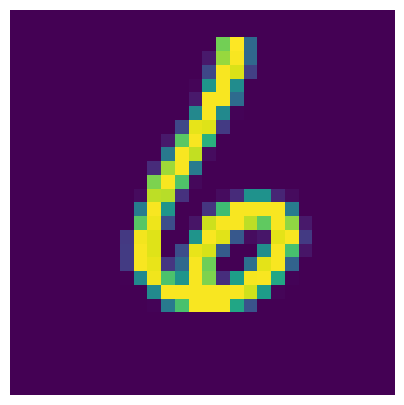

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(dataset_input[200], cmap="viridis")
ax.axis("off")
plt.show()

In [11]:
class invarCNN2DVAE_encoder(nn.Module):
    def __init__(self, final_length, channels, kernels, strides, paddings, pooling, z_dim, 
                 rot_check=True, trans_check=True, trans_std=0.1):
        super(invarCNN2DVAE_encoder, self).__init__()
        
        self.img_z_dim = z_dim        
        self.final_length = final_length
        self.channels = channels
        
        self.rot_check=rot_check
        self.trans_check=trans_check
        self.trans_std=trans_std
        
        self.z_dim = self.img_z_dim
        if self.rot_check:
            self.z_dim += 1
        if self.trans_check:
            self.z_dim += 2
        if not self.rot_check and not self.trans_check:
            print("Warning! at least one invariant property must be chosen")
            return
        
        enc_net = []
        enc_net.append(nn.Conv2d(1, channels[0], kernels[0], stride=strides[0], 
                                 padding=paddings[0], bias=True))
        enc_net.append(nn.BatchNorm2d(channels[0]))
        enc_net.append(nn.Tanh())
        if pooling[0] != 1:
            enc_net.append(nn.AvgPool2d(pooling[0]))
        for i in range(1, len(channels)):
            enc_net.append(nn.Conv2d(channels[i-1], channels[i], kernels[i], stride=strides[i],
                                     padding=paddings[i], bias=True))
            enc_net.append(nn.BatchNorm2d(channels[i]))
            enc_net.append(nn.Tanh())
            if pooling[i] != 1:
                enc_net.append(nn.AvgPool2d(pooling[i]))
            
        enc_net.append(nn.Flatten())
        enc_net.append(nn.Linear(final_length**2*channels[-1], 2*self.z_dim, bias=False))
        
        self.encoder = nn.Sequential(*enc_net)
        
    def encode(self, x):
        
        latent = self.encoder(x)
        mu = latent[:, :self.z_dim]
        logvar = latent[:, self.z_dim:]
        
        return mu, logvar
        
        
    def rotation(self, coord, z):
        rot_matrix = torch.stack((torch.cos(z), torch.sin(z), -torch.sin(z), torch.cos(z)), dim=1)
        rot_matrix = rot_matrix.view(-1, 2, 2)
        
        return torch.bmm(coord, rot_matrix)
        
        
    def translation(self, coord, z):
        trans_z = z * self.trans_std
        trans_z = trans_z.unsqueeze(1)
        
        return coord + trans_z
        
                
    def reparametrization(self, mu, logvar):
        
        return mu+torch.exp(0.5*logvar)*torch.randn_like(logvar)
        
        
    def forward(self, x, coord):
        if coord.size(0) != x.size(0):
            coord = coord[:x.size(0)]
        
        x = x.unsqueeze(1)
        mu, logvar = self.encode(x)
        z = self.reparametrization(mu, logvar)
        
        rot_mu=None
        rot_logvar=None
        rot_z=None
        
        trans_mu=None
        trans_logvar=None
        trans_z=None
        
        if self.rot_check:
            rot_mu = mu[:, 0]
            mu = mu[:, 1:]
            
            rot_logvar = logvar[:, 0]
            logvar = logvar[:, 1:]
            
            rot_z = z[:, 0]
            z = z[:, 1:]
            
            coord = self.rotation(coord, rot_z)
            
        if self.trans_check:
            trans_mu = mu[:, :2]
            mu = mu[:, 2:]
            
            trans_logvar = logvar[:, :2]
            logvar = logvar[:, 2:]
            
            trans_z = z[:, 2:]
            z = z[:, 2:]
            
            coord = self.translation(coord, trans_z)
        
        return coord, mu, logvar, z, rot_mu, rot_logvar, rot_z, trans_mu, trans_logvar, trans_z

In [12]:
class invarCNN2DVAE_decoder(nn.Module):
    def __init__(self, n_coord, n_dim, z_dim, hid_dim, dec_kernels, dec_poolings, w_size, bi_lin=False):
        super(invarCNN2DVAE_decoder, self).__init__()
        
        self.n_coord = n_coord
        self.n_dim = n_dim
        self.z_dim = z_dim
        self.bi_lin = bi_lin
        self.w_size = w_size
        
        self.linear_coord = nn.Linear(n_dim, hid_dim, bias=False)
        self.linear_img = nn.Linear(z_dim, hid_dim, bias=False)
        if bi_lin:
            self.bi_linear = nn.Bilinear(n_dim, z_dim, hid_dim, bias=False)
        
        dec_net = []
        for i in range(len(dec_kernels)-1):
            dec_net.append(nn.Conv1d(n_coord, n_coord, dec_kernels[i], bias=True))
            dec_net.append(nn.BatchNorm1d(n_coord))
            dec_net.append(nn.Tanh())
            dec_net.append(nn.AvgPool1d(dec_poolings[i]))
    
        dec_net.append(nn.Conv1d(n_coord, n_coord, dec_kernels[-1], bias=True))
        dec_net.append(nn.BatchNorm1d(n_coord))
        dec_net.append(nn.Sigmoid())
        dec_net.append(nn.AvgPool1d(dec_poolings[-1]))
        
        self.decoder = nn.Sequential(*dec_net)
        
        
    def forward(self, coord, z):
        if coord.size(0) != z.size(0):
            coord = coord[:z.size(0)]
        img_tmp = self.linear_img(z)
        z = z.unsqueeze(1)
        z = z.expand(z.size(0), self.n_coord, self.z_dim).contiguous()
        if self.bi_lin:
            bi_tmp = self.bi_linear(coord, z)
        coord = coord.view(coord.size(0)*coord.size(1), -1).contiguous()
        coord_tmp = self.linear_coord(coord)
        
        #print(img_tmp.shape, bi_tmp.shape, coord_tmp.shape)
        img_tmp = img_tmp.unsqueeze(1)
        coord_tmp = coord_tmp.view(z.size(0), self.n_coord, -1)
        #print(img_tmp.shape, bi_tmp.shape, coord_tmp.shape)
        
        
        if self.bi_lin:
            init_dec = coord_tmp + img_tmp + bi_tmp
        else:
            init_dec = coord_tmp + img_tmp
        #print(init_dec.shape)
        
        output = self.decoder(init_dec)
        
        return output.view(z.size(0), self.w_size, self.w_size)

In [13]:
if torch.cuda.is_available():
    print("%d gpu available"%(torch.cuda.device_count()))
    cuda_device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(cuda_device))
    torch.cuda.set_device(cuda_device)
    print(torch.cuda.memory_summary(device=cuda_device))
else:
    cuda_device = None

2 gpu available
Tesla V100S-PCIE-32GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool | 

In [14]:
num_comp = 2
channels = [16, 32, 64]
kernels = [3, 3, 3]
padding = [1, 1, 1]
stride = [1, 1, 1]
pooling = [2, 2, 2]

dat_dim = []
tmp_dim = w_size
for i in range(len(kernels)):
    tmp_dim += (-kernels[i]+2*padding[i])
    tmp_dim /= stride[i]
    tmp_dim += 1
    tmp_dim /= pooling[i]
    dat_dim.append(int(tmp_dim))

print(dat_dim)
print(kernels)
print(channels)
print(padding)
print(stride)
print(pooling)

[14, 7, 3]
[3, 3, 3]
[16, 32, 64]
[1, 1, 1]
[1, 1, 1]
[2, 2, 2]


In [15]:
dec_kernel = [32, 32, 32, 32]
dec_pooling = [2, 2, 2, 2]

dec_dim = []
hid_dim = 512
tmp_dim = hid_dim
for i in range(len(dec_kernel)):
    tmp_dim += (-dec_kernel[i]+1)
    tmp_dim /= dec_pooling[i]
    dec_dim.append(int(tmp_dim))
    
dec_kernel[-1] = dec_dim[-2] - dec_pooling[-1] + 1
dec_dim[-1] = 1

print(dec_kernel)
print(dec_pooling)
print(dec_dim)

[32, 32, 32, 35]
[2, 2, 2, 2]
[240, 104, 36, 1]


In [16]:
batch_size = 2000
mini_batches = [dataset_input[k:k+batch_size] for k in range(0, len(dataset_input), batch_size)]
print(len(mini_batches))
print(len(mini_batches[-1]))

15
2000


In [17]:
grid = np.linspace(1, -1, w_size)
X, Y = np.meshgrid(grid, grid)
img_coord = np.stack([X.ravel(), Y.ravel()], 1)
img_coord = torch.from_numpy(img_coord)
img_coord = img_coord.to(torch.float32)
img_coord = img_coord.requires_grad_(requires_grad=False)
n_dim = img_coord.size(1)
print(img_coord.shape)

torch.Size([784, 2])


In [18]:
coord = img_coord.expand(batch_size, img_coord.size(0), img_coord.size(1))
coord = coord.requires_grad_(requires_grad=False)
coord = coord.to(cuda_device)
n_coord = coord.size(1)
print(n_coord)
print(coord.shape)

784
torch.Size([2000, 784, 2])


In [19]:
rotation_check = True
angle_std = np.pi
translation_check = False
translation_std = 0.1
enc_model = invarCNN2DVAE_encoder(dat_dim[-1], channels, kernels, stride, padding, pooling, num_comp,
                                 rotation_check, translation_check, translation_std)
enc_model = nn.DataParallel(enc_model)
enc_model.cuda(cuda_device)
print(enc_model)

DataParallel(
  (module): invarCNN2DVAE_encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Tanh()
      (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Tanh()
      (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=576, out_features=6, bias=False)
    )
  )
)


In [20]:
dec_model = invarCNN2DVAE_decoder(n_coord, n_dim, num_comp, hid_dim, dec_kernel, 
                                  dec_pooling, w_size, bi_lin=True)
dec_model = nn.DataParallel(dec_model)
dec_model.cuda(cuda_device)
print(dec_model)

DataParallel(
  (module): invarCNN2DVAE_decoder(
    (linear_coord): Linear(in_features=2, out_features=512, bias=False)
    (linear_img): Linear(in_features=2, out_features=512, bias=False)
    (bi_linear): Bilinear(in1_features=2, in2_features=2, out_features=512, bias=False)
    (decoder): Sequential(
      (0): Conv1d(784, 784, kernel_size=(32,), stride=(1,))
      (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (4): Conv1d(784, 784, kernel_size=(32,), stride=(1,))
      (5): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Tanh()
      (7): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (8): Conv1d(784, 784, kernel_size=(32,), stride=(1,))
      (9): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Tanh()
      (11): AvgPool1d(kernel_size=(2,), stride=(2,)

In [ ]:
for i in range(1):
    x = torch.from_numpy(mini_batches[i]).clamp_(min=0.01, max=0.99)
    x = x.to(torch.float32)
    x = x.to(cuda_device)
    x.requires_grad_(requires_grad=False)
    
    #with torch.cuda.amp.autocast():
    tf_coord, mu, logvar, z, rot_mu, rot_logvar, rot_z, trans_mu, trans_logvar, trans_z = enc_model(x, coord)
    x_ = dec_model(tf_coord.contiguous(), z)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(x[0].data.cpu().numpy().astype(np.float32), cmap="viridis")
    ax.axis("off")
    plt.show()
    
    print(x.shape, x_.shape)
    print(x.min(), x.max())
    print(x_.min(), x_.max())
    print(x.dtype, x_.dtype)
    print(torch.sum(x-x_.squeeze()))
    
    #reconstruction_error = F.binary_cross_entropy(x_.squeeze(), x, reduction="mean")
    #if torch.isinf(reconstruction_error):
    #    print(x.shape)
    #    print(x_.shape)
    #    print(x.min(), x.max())
    #    print(x_.min(), x_.max())   
    #    print(i, reconstruction_error)

In [21]:
n_epoch = 100
l_rate = 0.01
params = list(enc_model.parameters()) + list(dec_model.parameters())
optimizer = optim.Adam(params, lr=l_rate)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1262 MB |   13915 MB |     998 GB |     996 GB |
|       from large pool |    1261 MB |   13914 MB |     998 GB |     996 GB |
|       from small pool |       0 MB |       1 MB |       0 GB |       0 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1268 MB |   13915 MB |     998 GB |     996 GB |
|       from large pool |    1267 MB |   13914 MB |     998 GB |

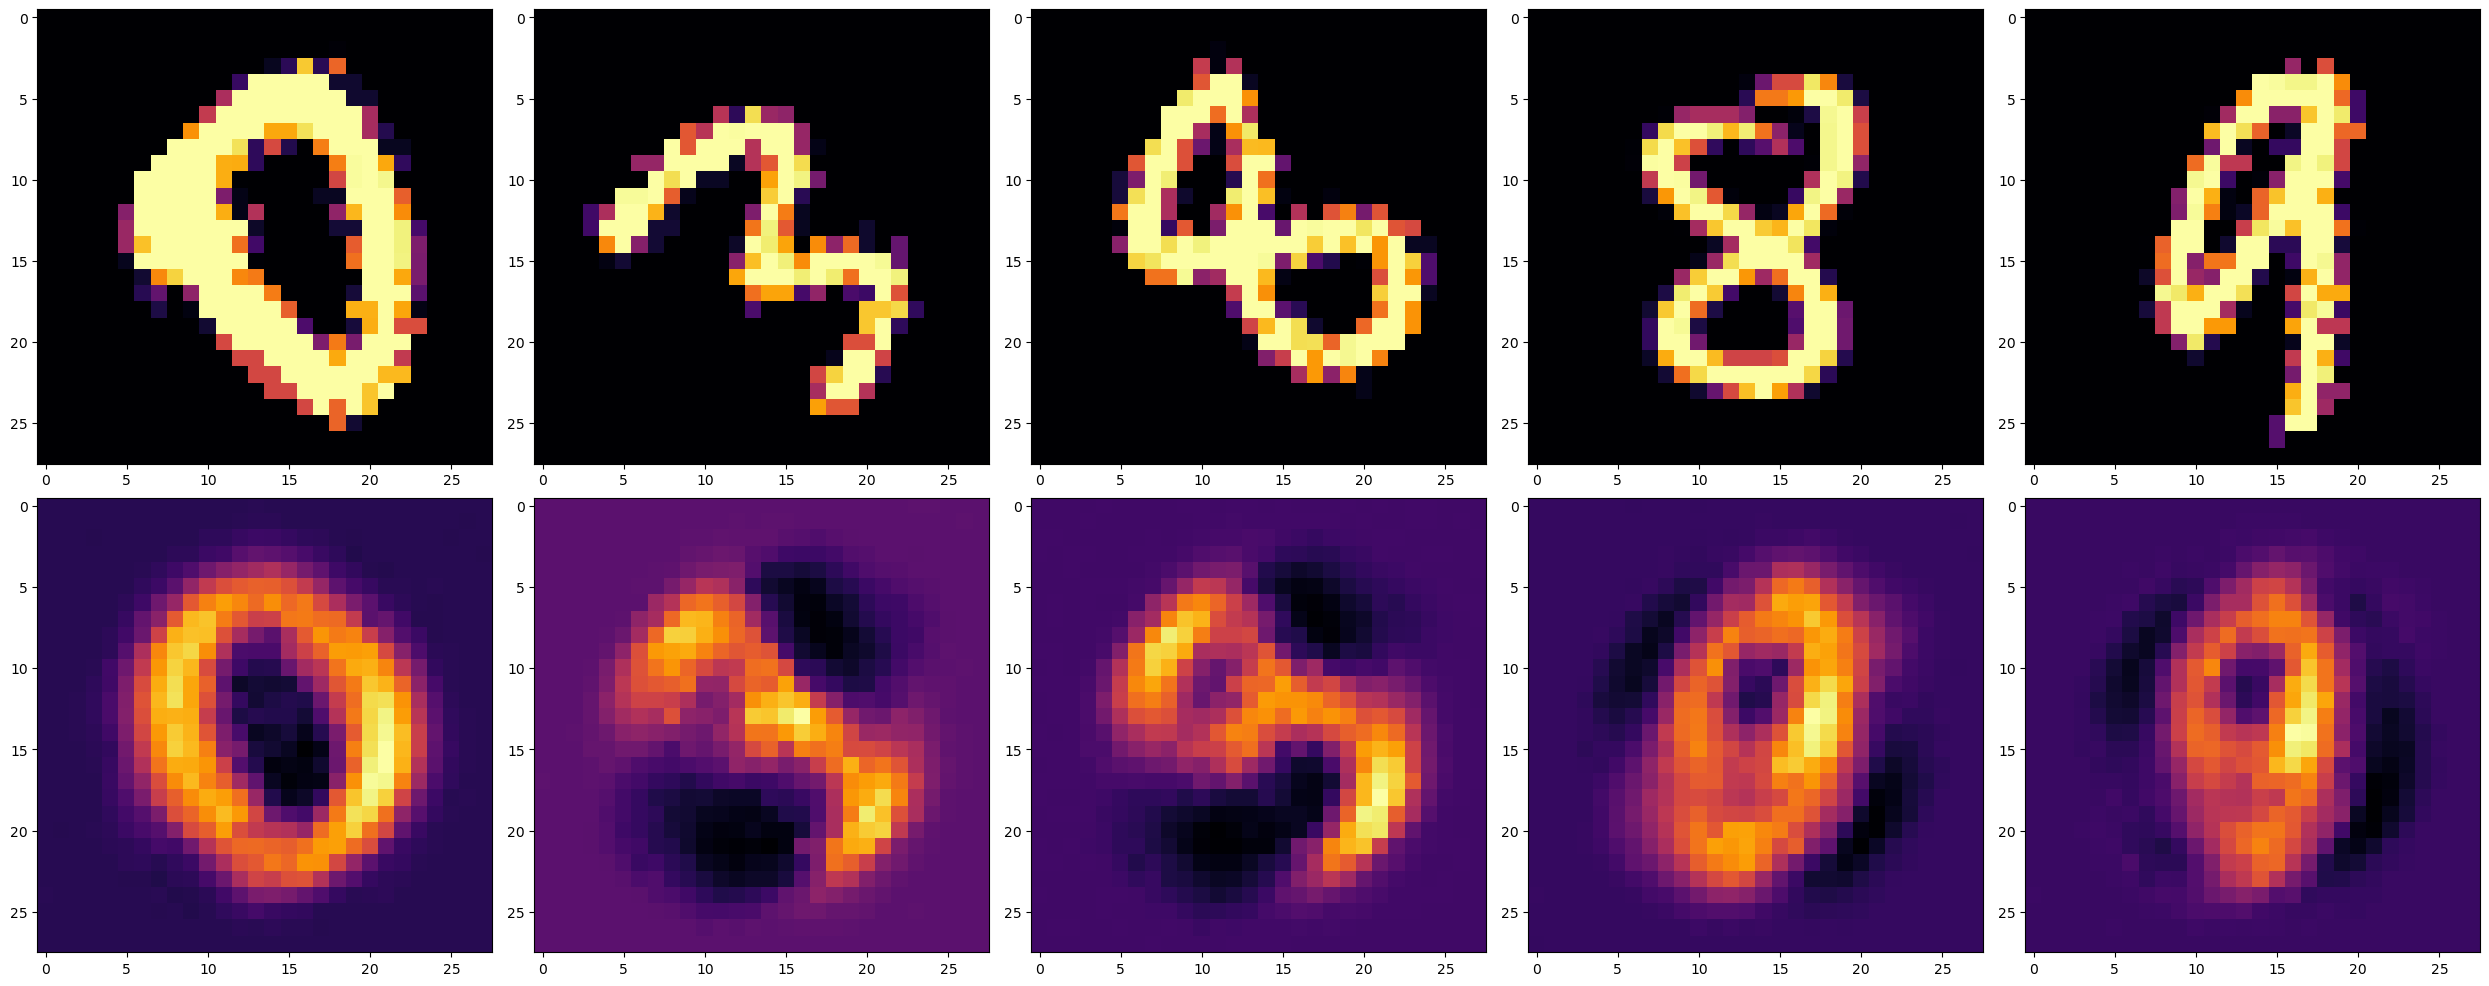

------------------------  --------
epoch                      20
total loss                226.314
reconstruction error      218.241
KL divergence               4.6091
KL divergence (rotation)    3.4631
------------------------  --------
67.87 minutes have passed


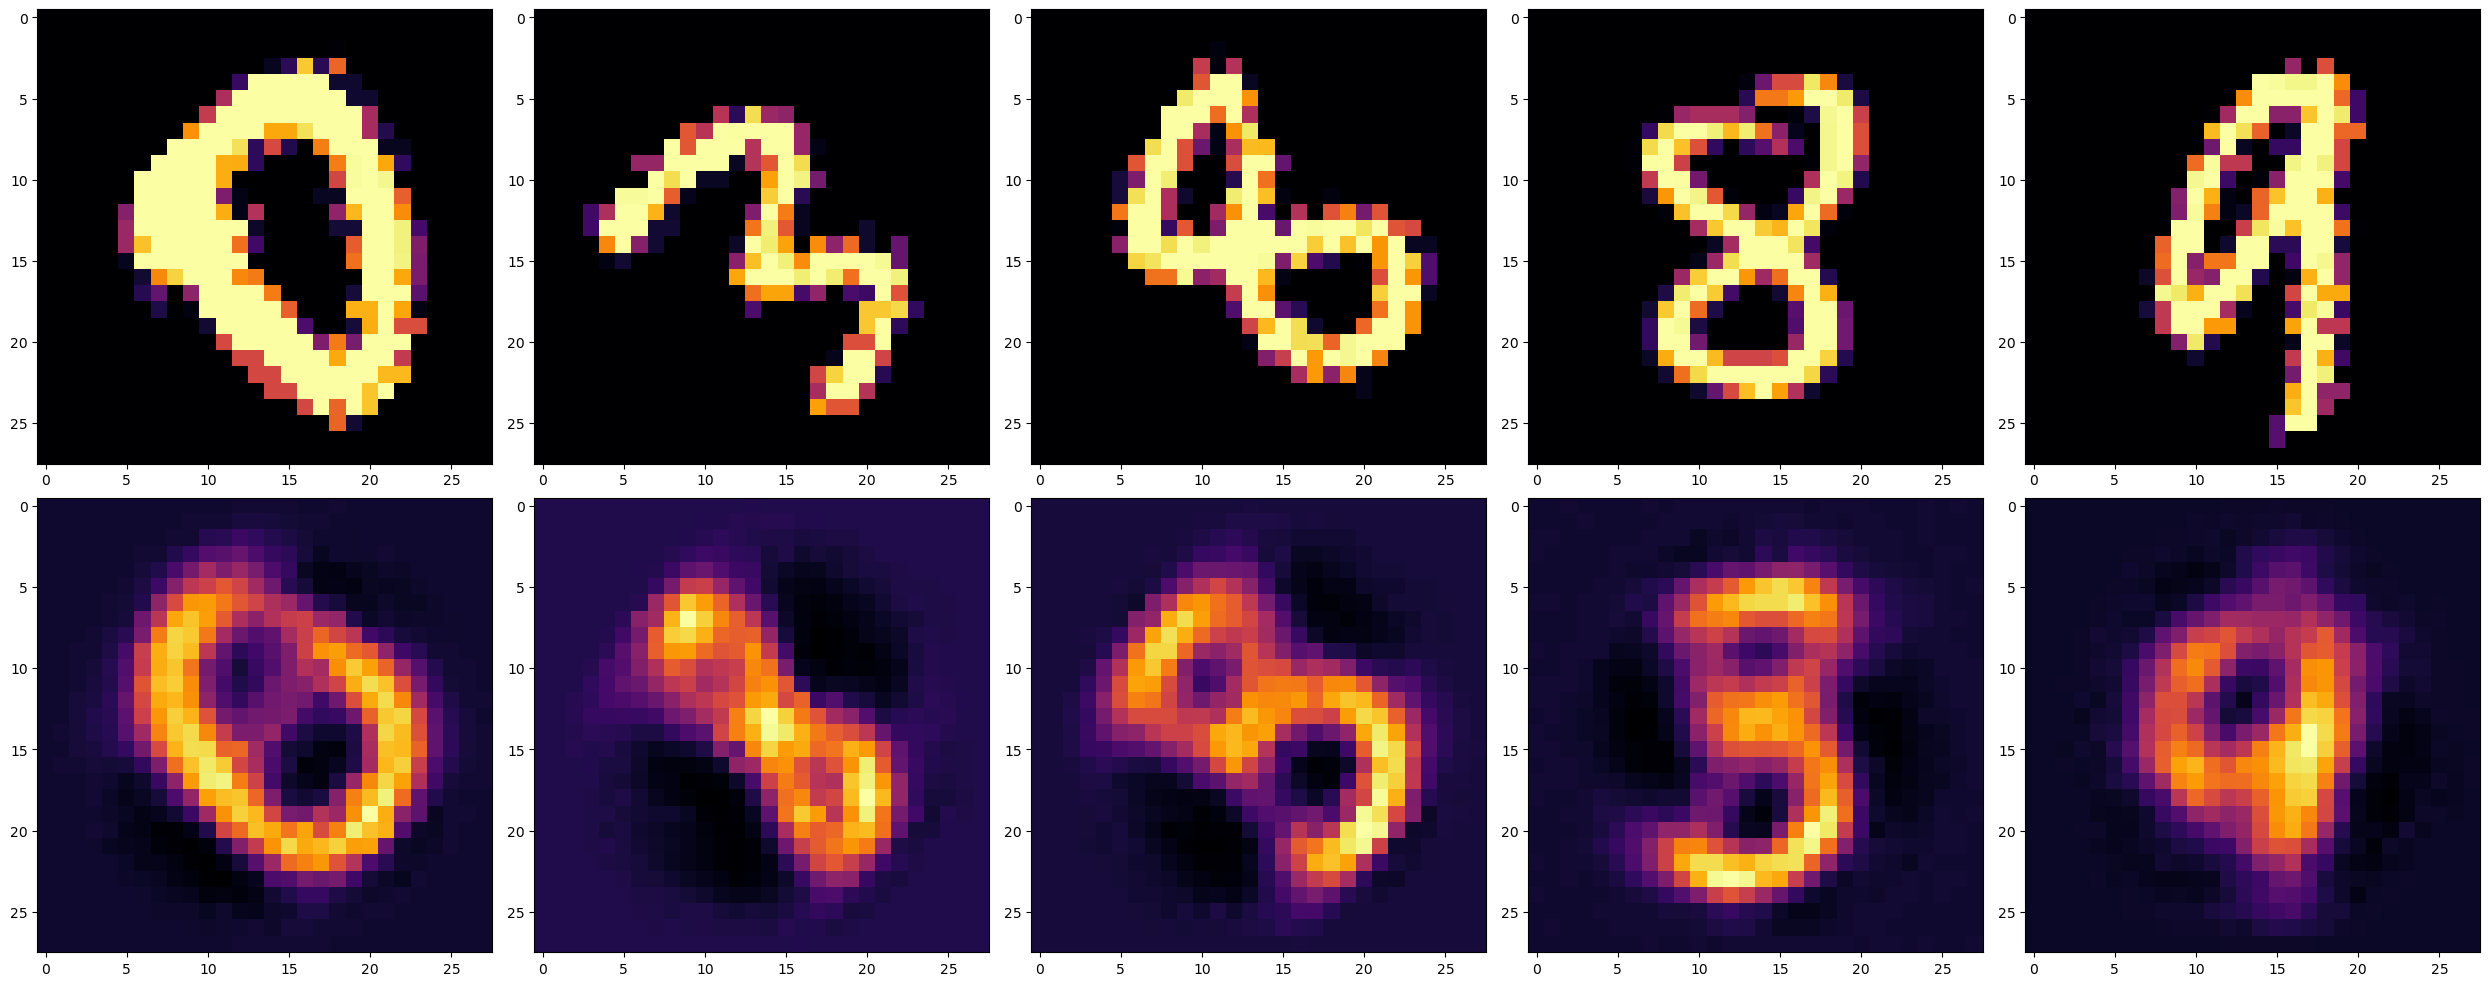

------------------------  ---------
epoch                      30
total loss                201.969
reconstruction error      192.936
KL divergence               5.00654
KL divergence (rotation)    4.02607
------------------------  ---------
103.10 minutes have passed


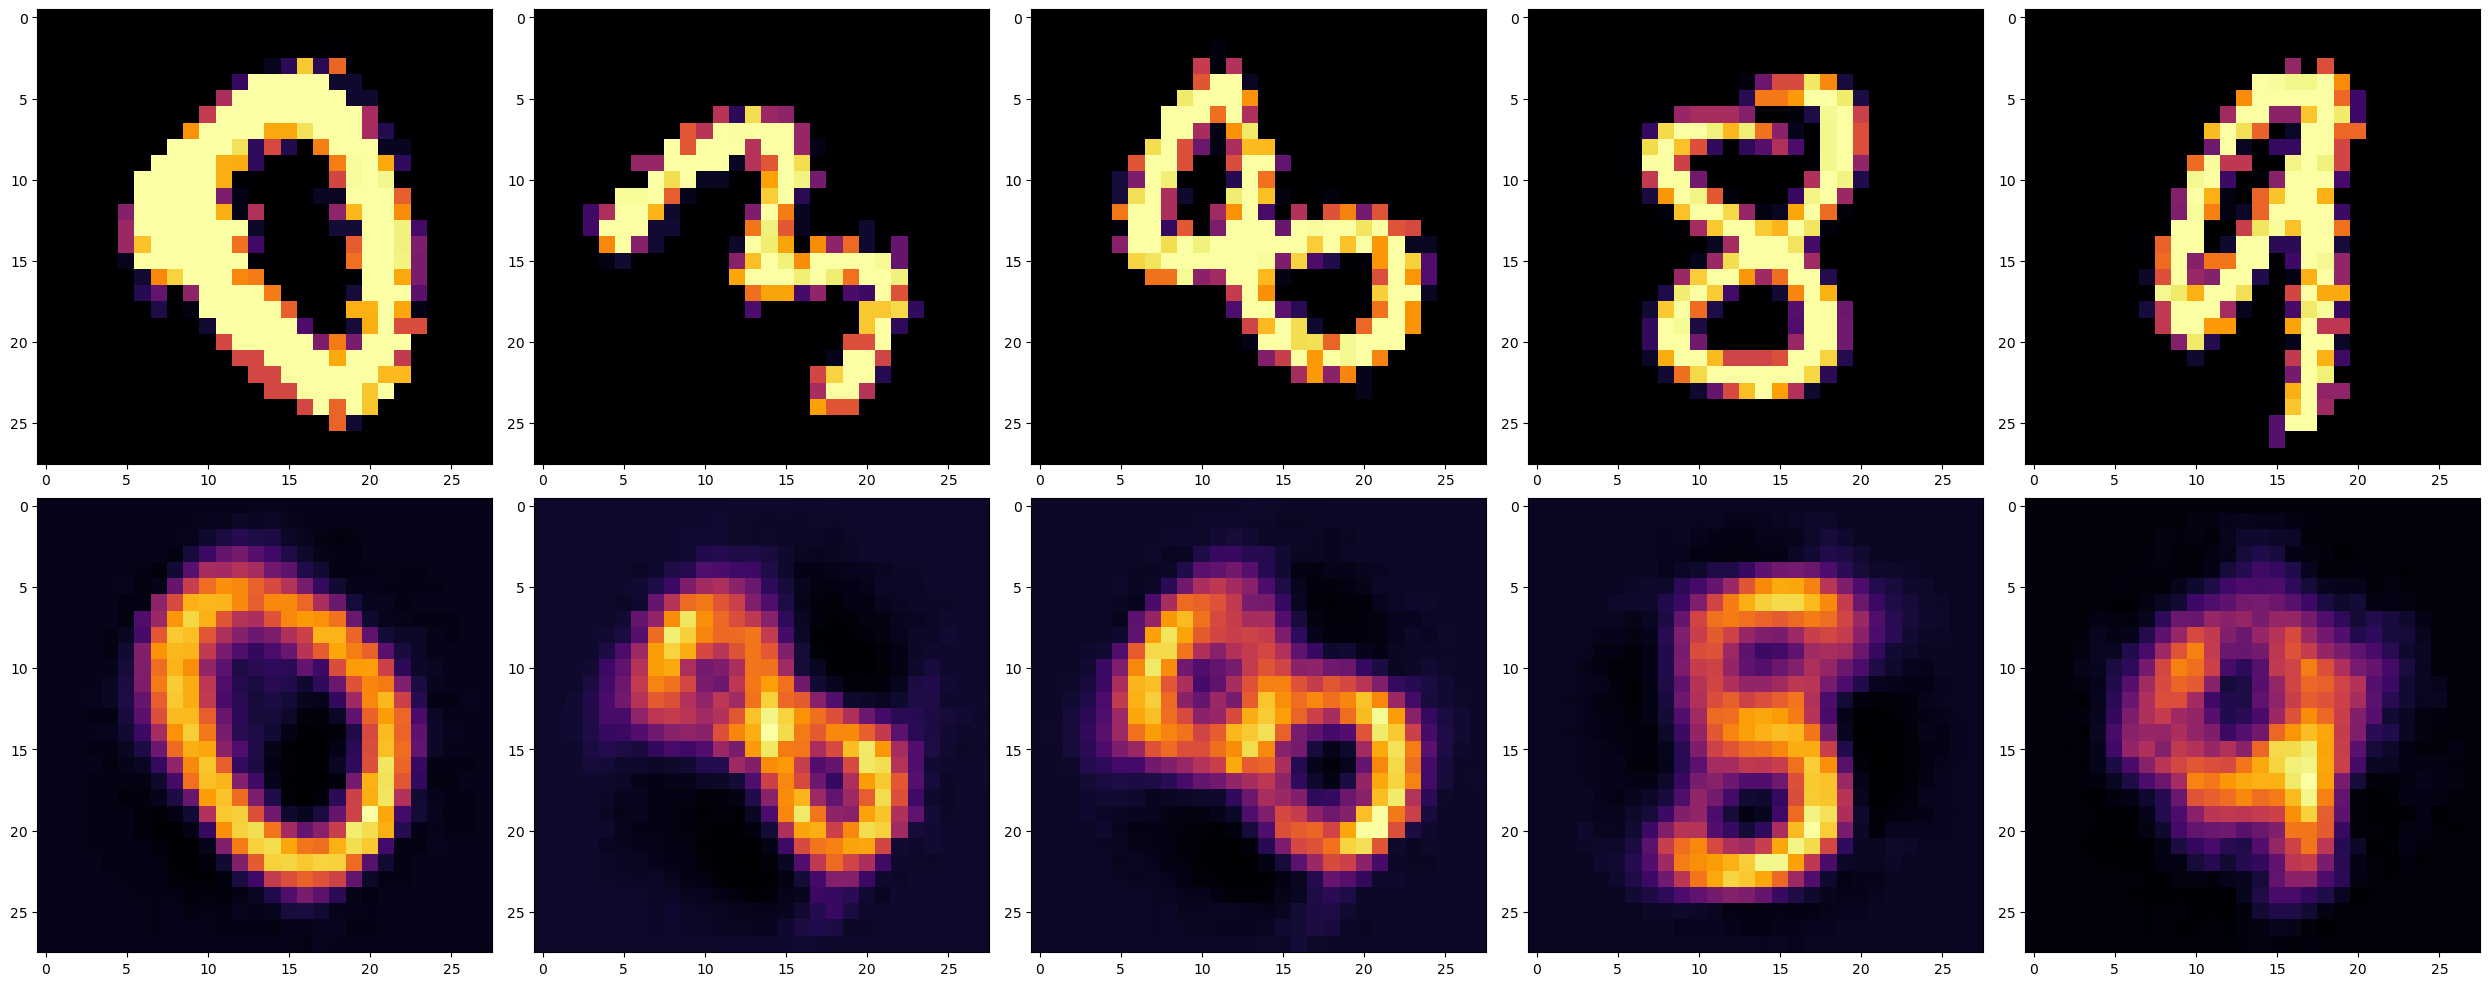

------------------------  ---------
epoch                      40
total loss                191.561
reconstruction error      182.035
KL divergence               5.24896
KL divergence (rotation)    4.27656
------------------------  ---------
138.05 minutes have passed


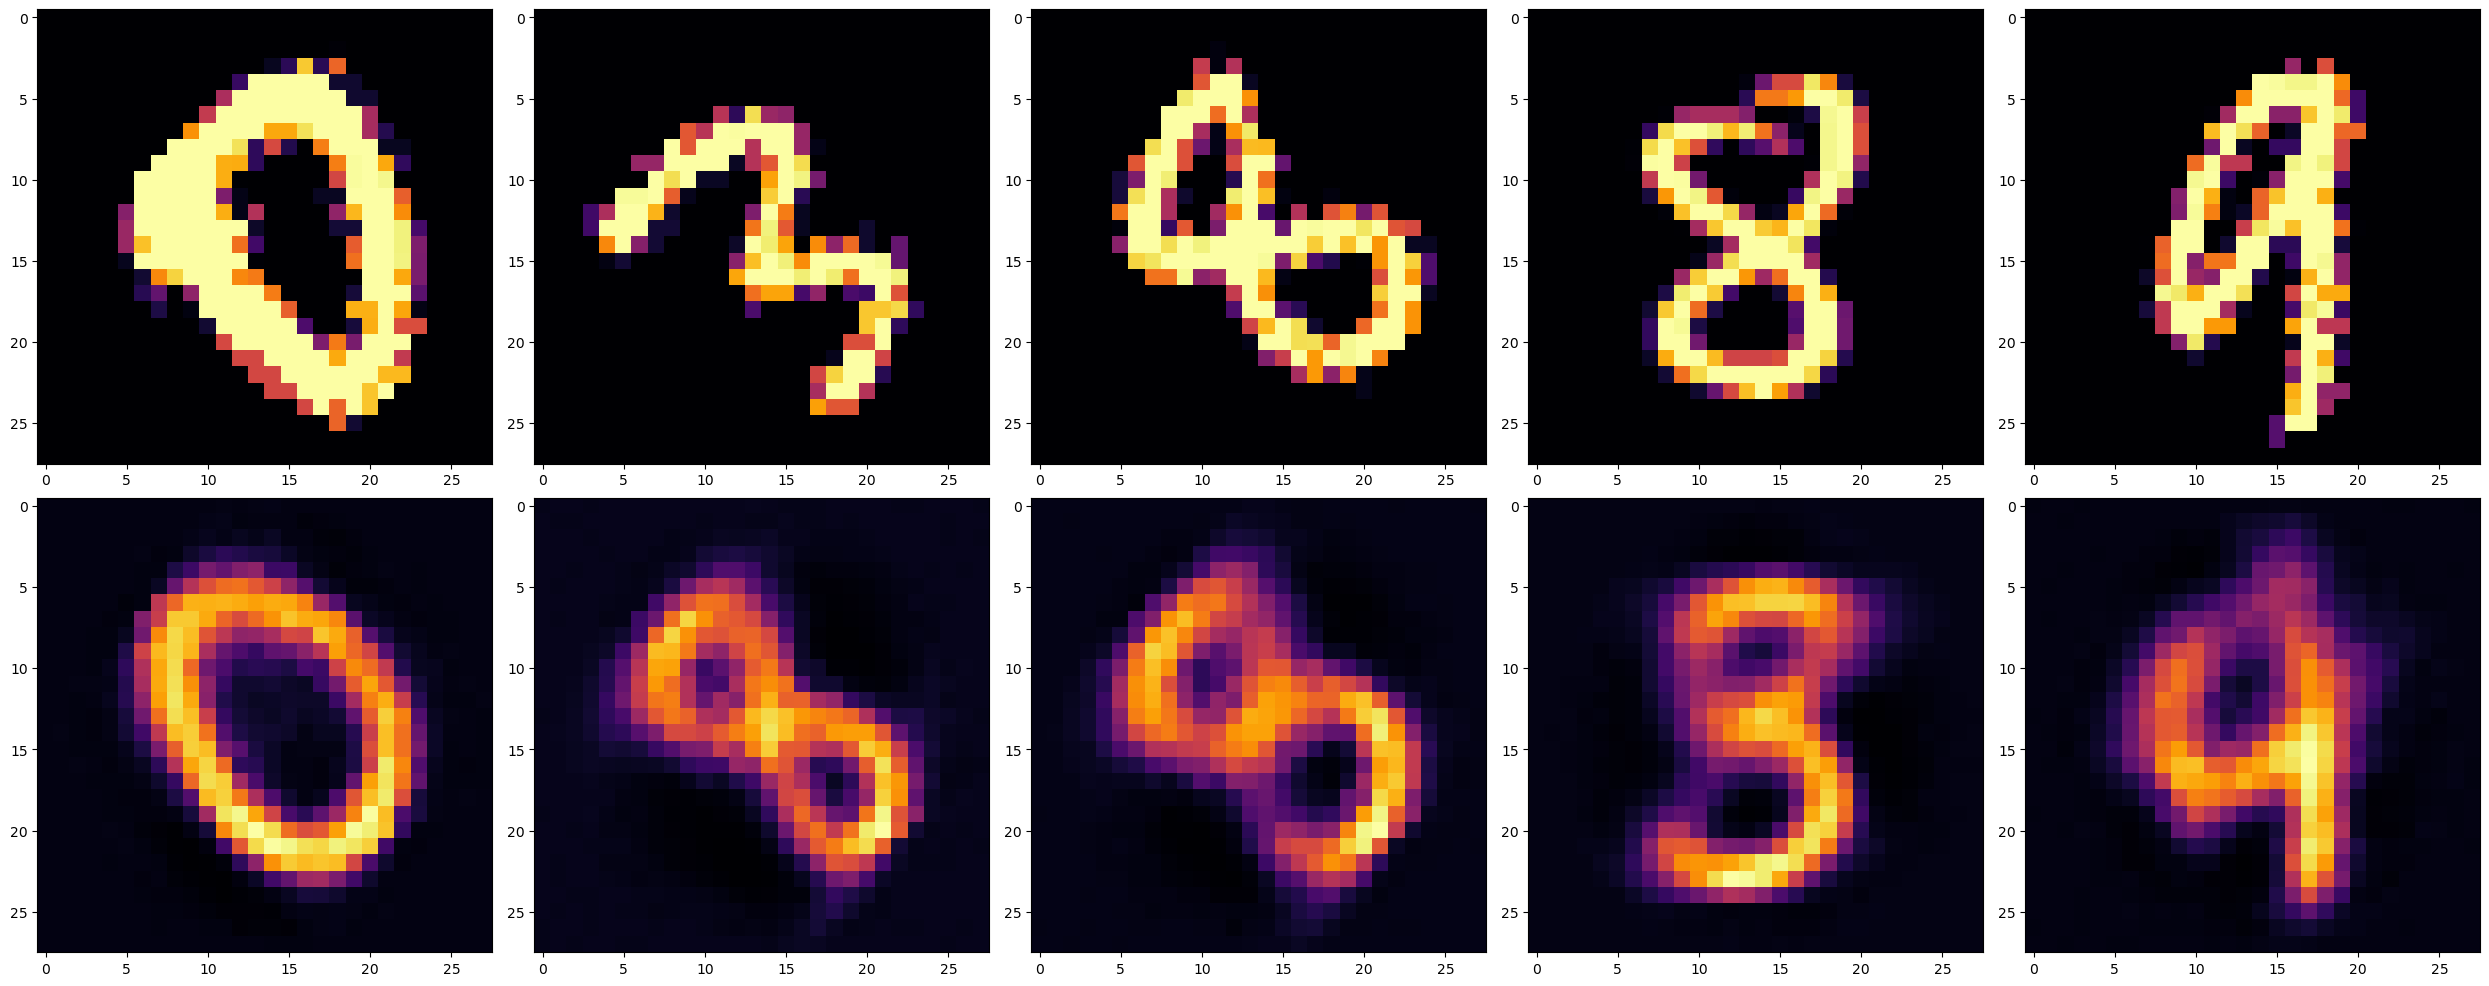

------------------------  ---------
epoch                      50
total loss                185.954
reconstruction error      176.137
KL divergence               5.39652
KL divergence (rotation)    4.42087
------------------------  ---------
173.23 minutes have passed


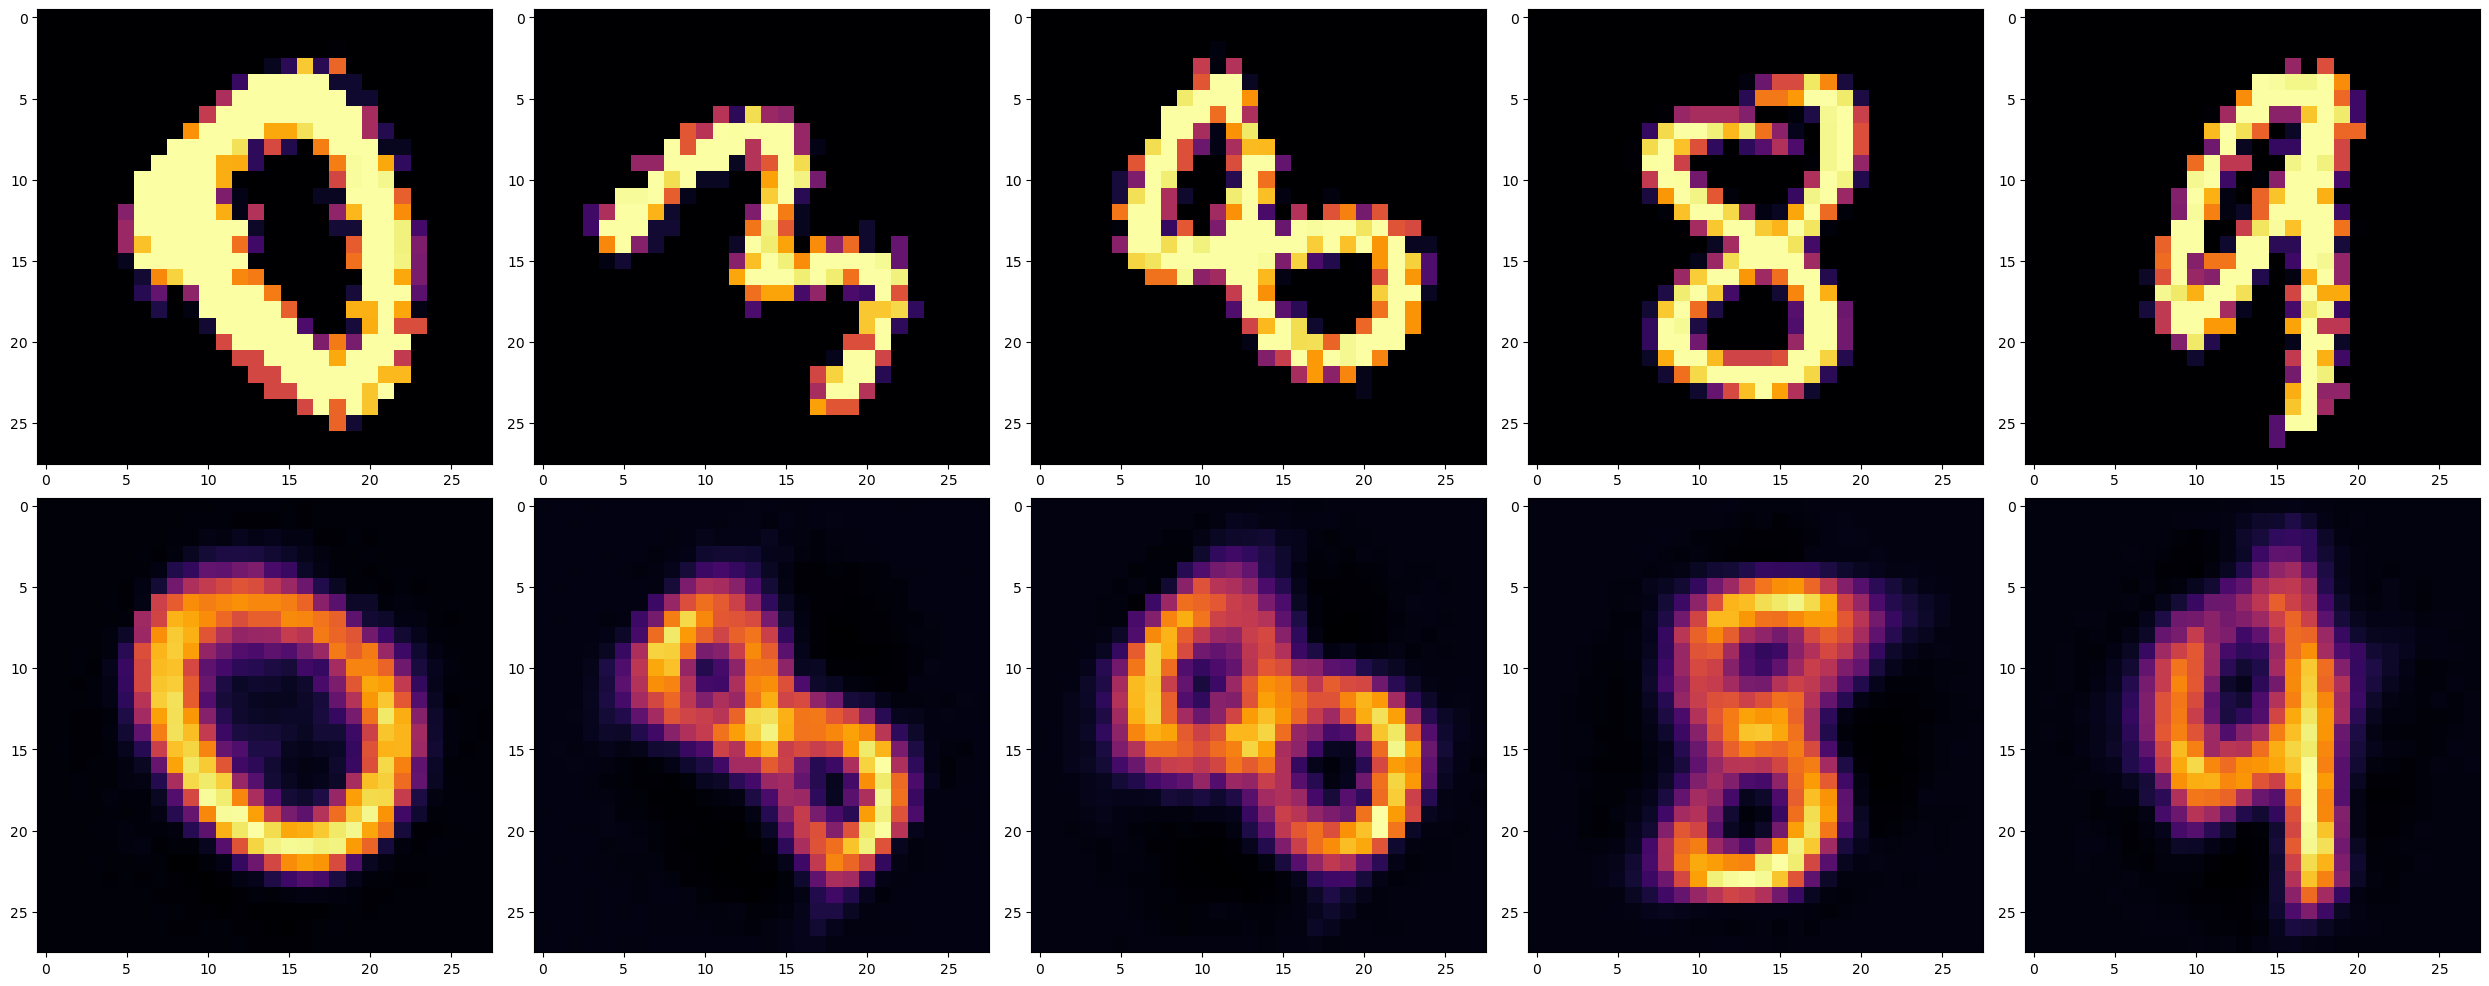

------------------------  ---------
epoch                      60
total loss                182.26
reconstruction error      172.143
KL divergence               5.55047
KL divergence (rotation)    4.56678
------------------------  ---------
208.54 minutes have passed


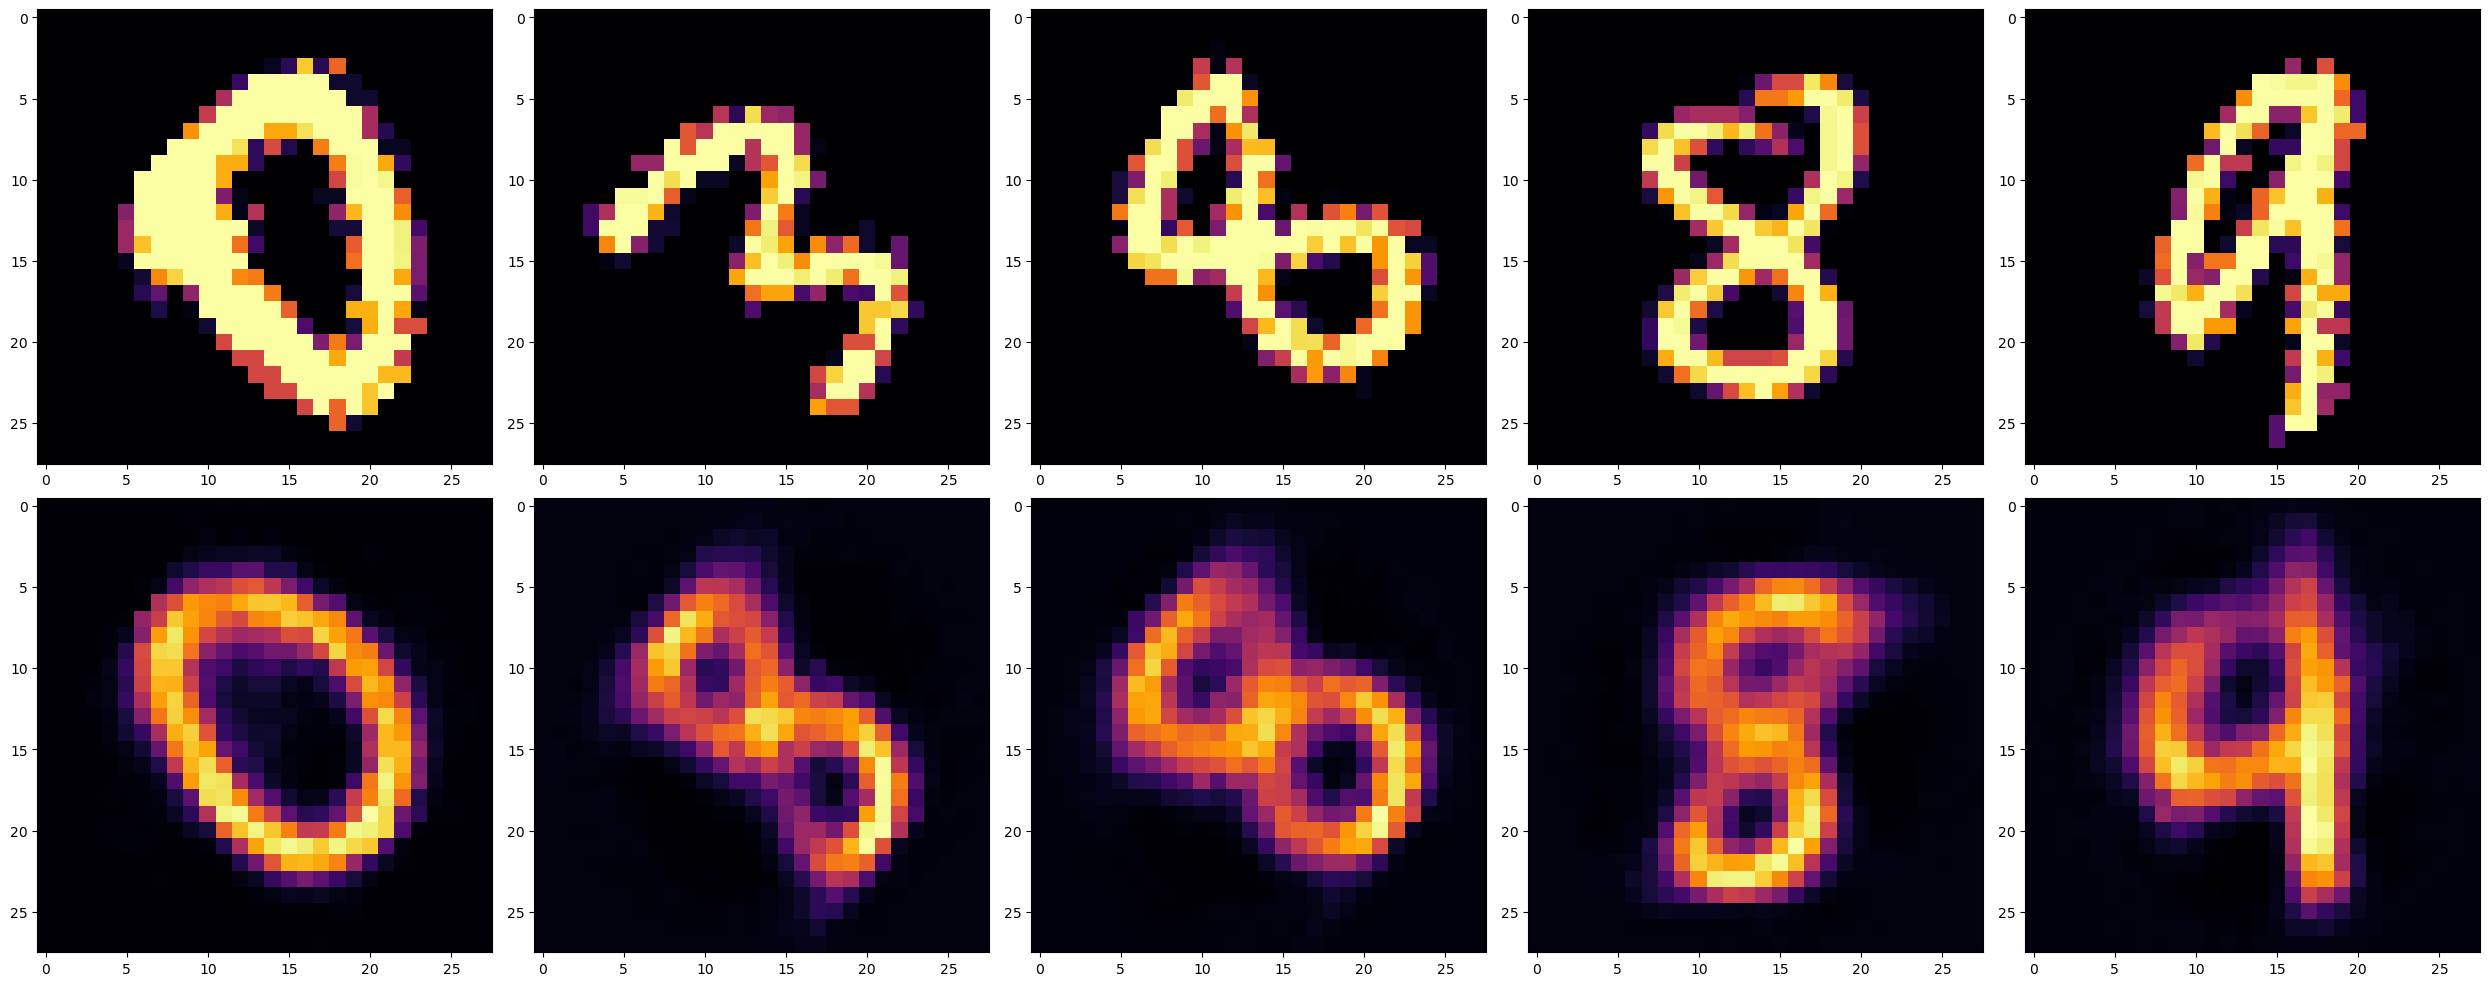

------------------------  ---------
epoch                      70
total loss                180.978
reconstruction error      170.639
KL divergence               5.66327
KL divergence (rotation)    4.67577
------------------------  ---------
243.78 minutes have passed


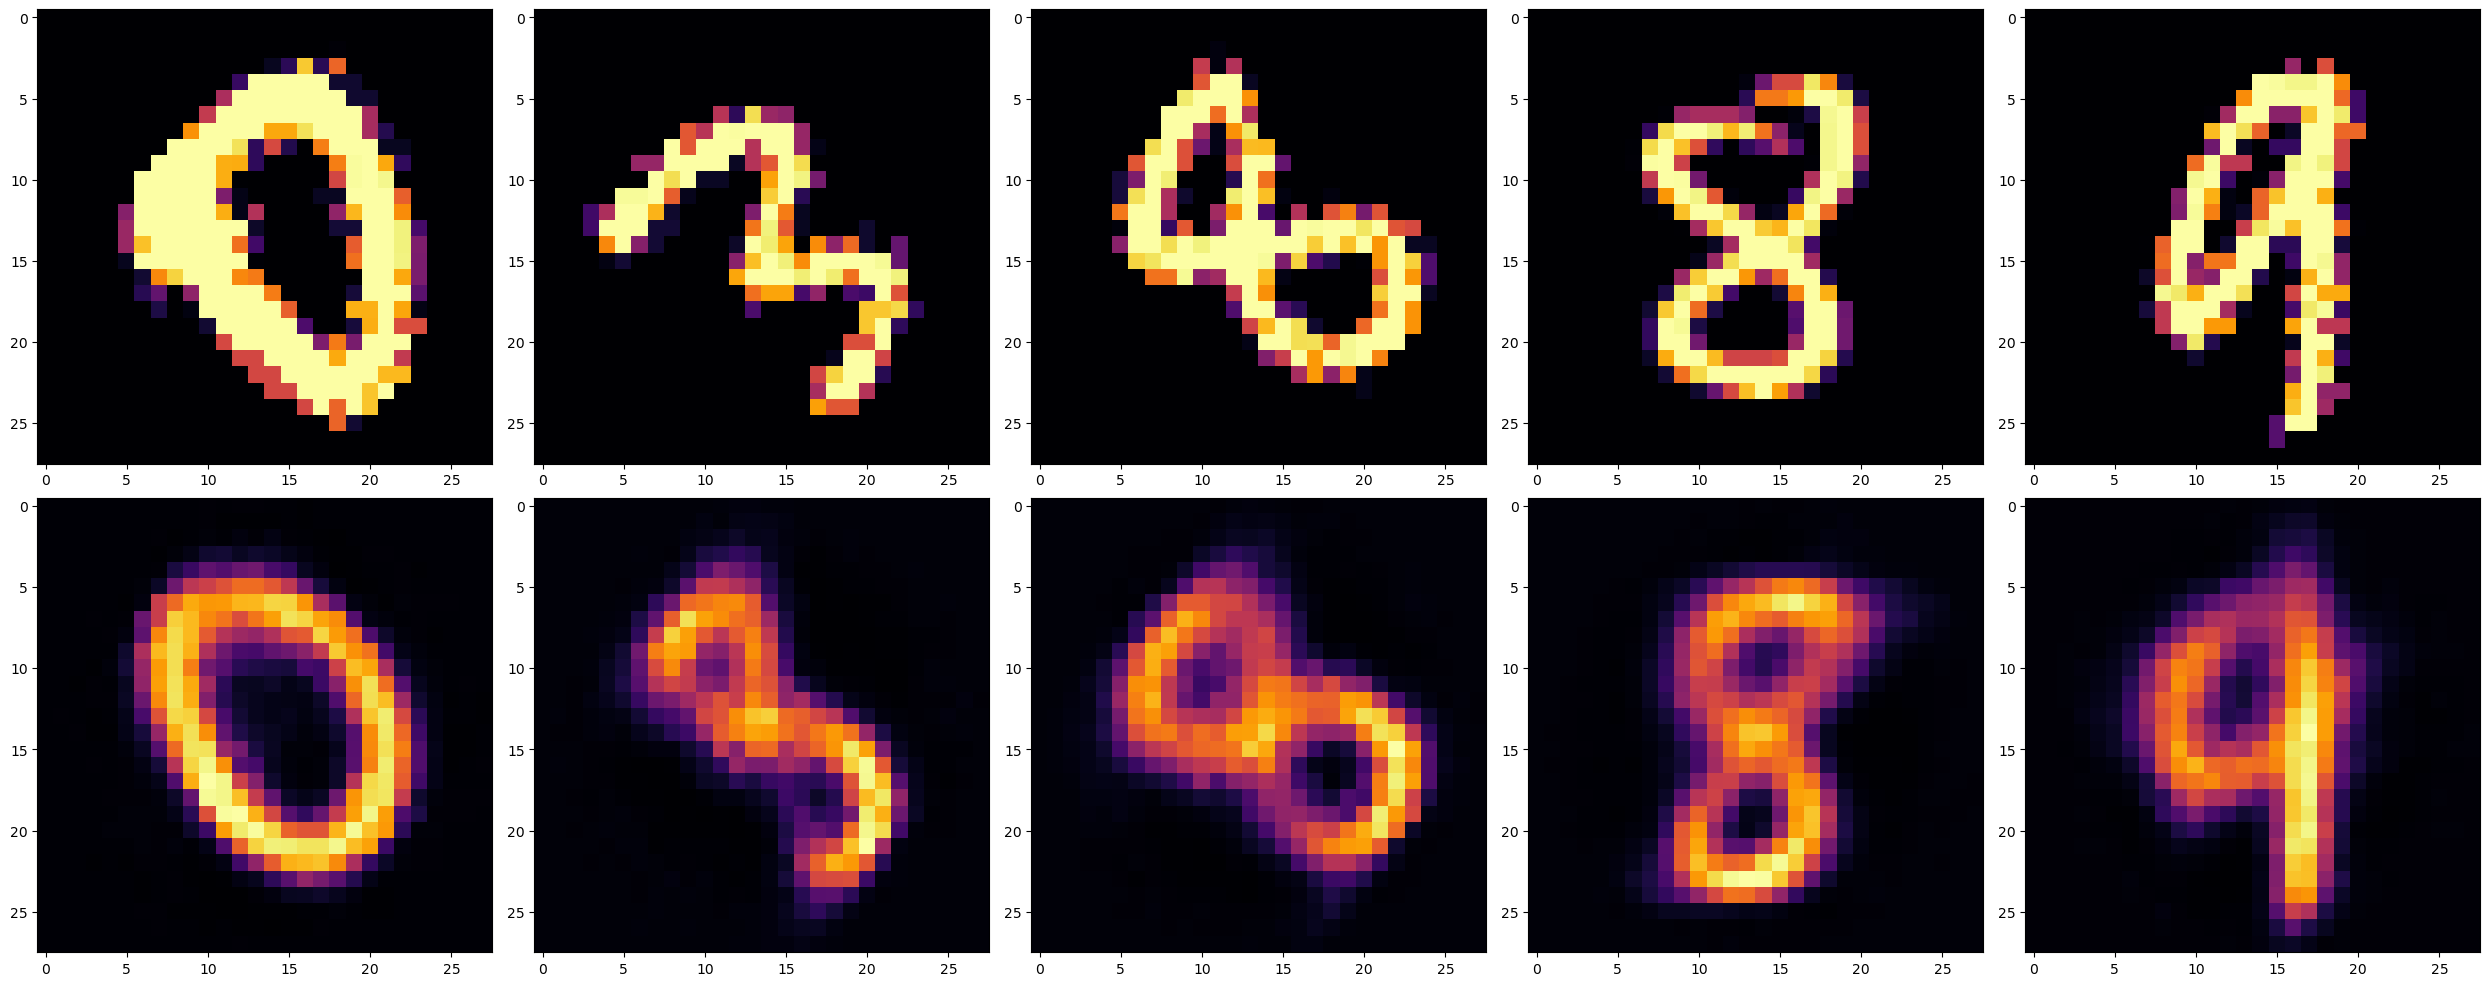

------------------------  ---------
epoch                      80
total loss                178.906
reconstruction error      168.423
KL divergence               5.73478
KL divergence (rotation)    4.74854
------------------------  ---------
278.48 minutes have passed


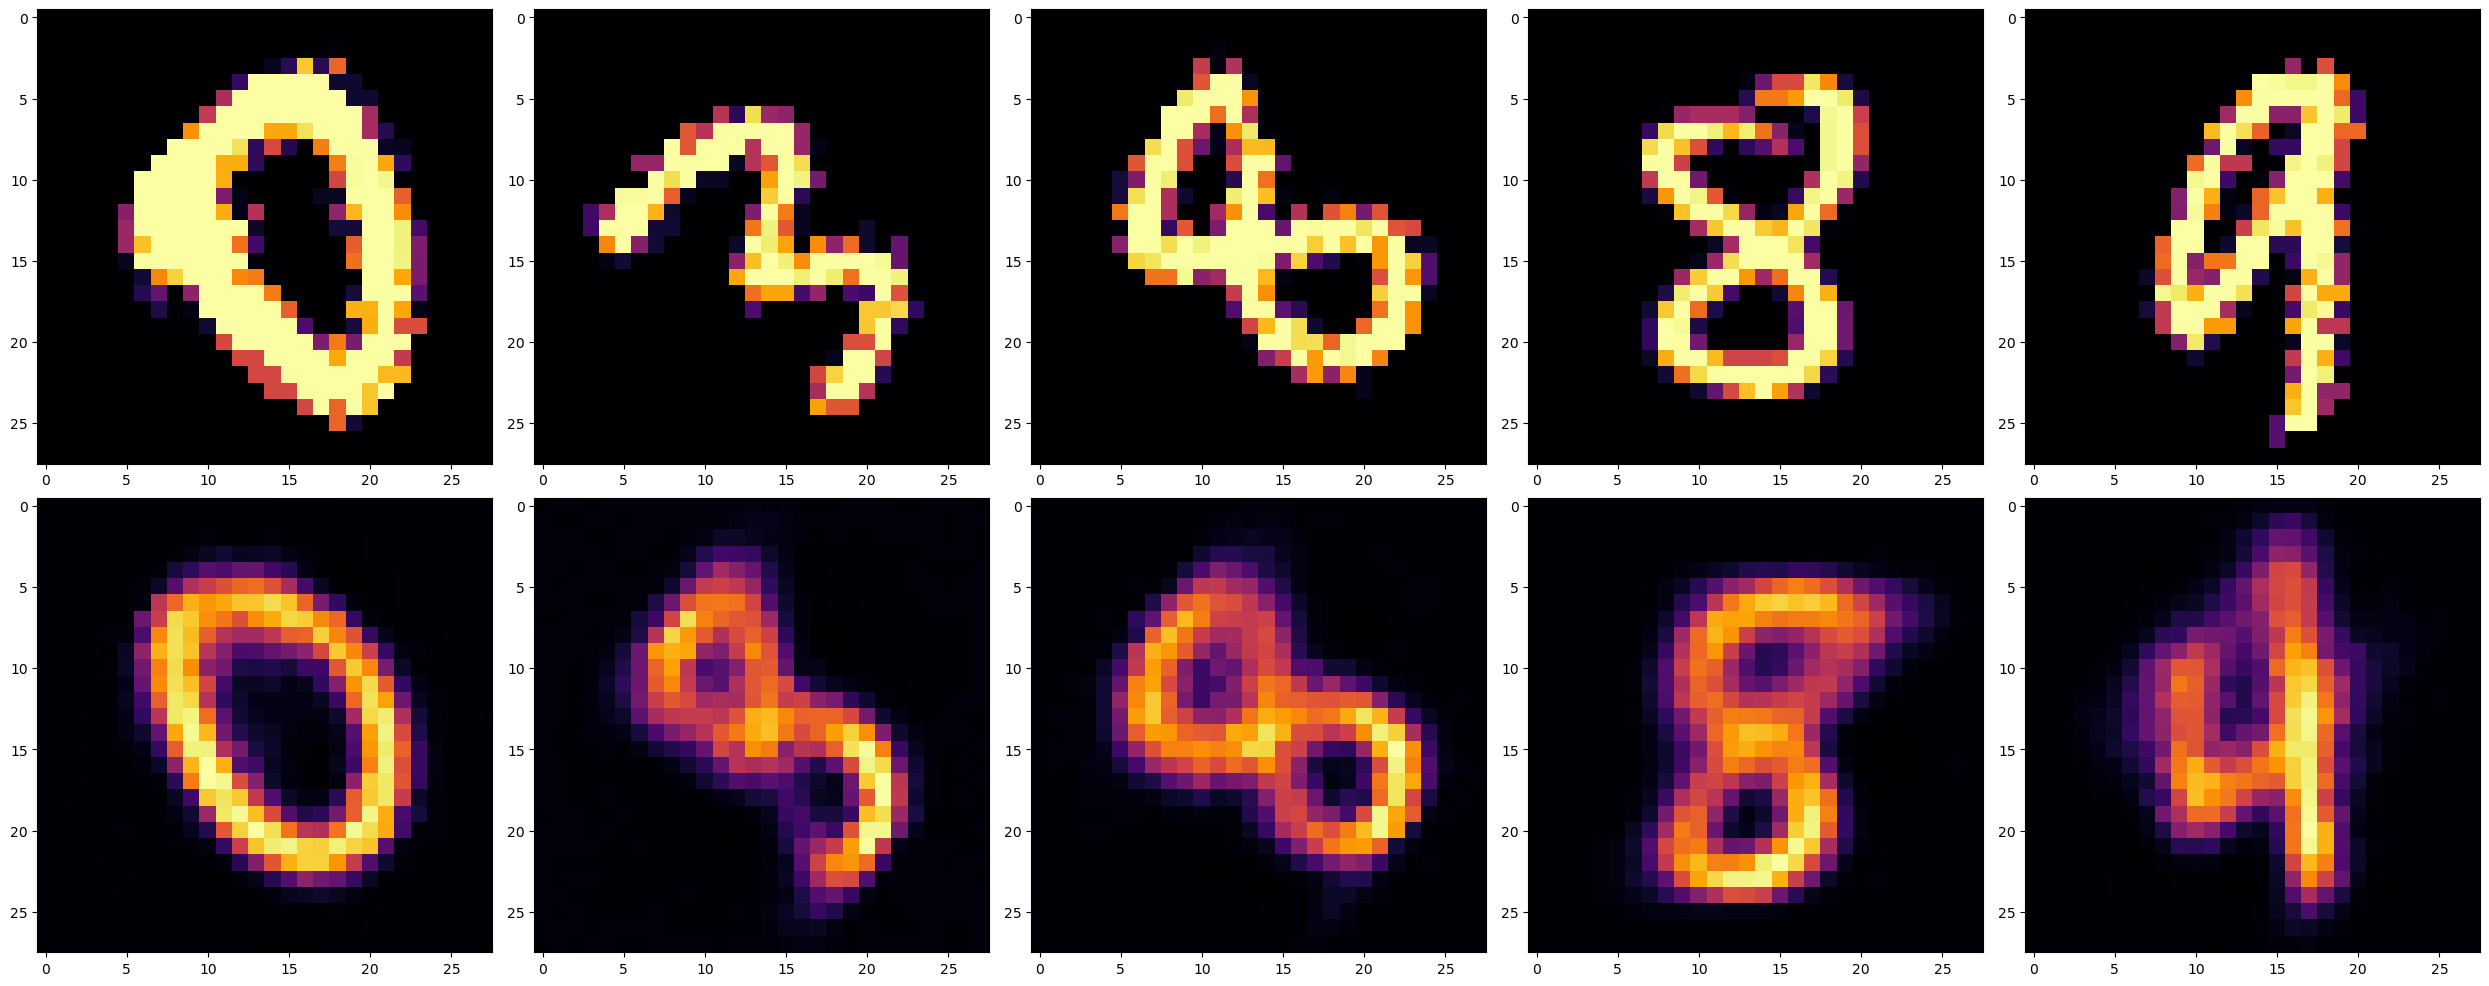

------------------------  ---------
epoch                      90
total loss                177.75
reconstruction error      167.071
KL divergence               5.8257
KL divergence (rotation)    4.85389
------------------------  ---------
312.71 minutes have passed


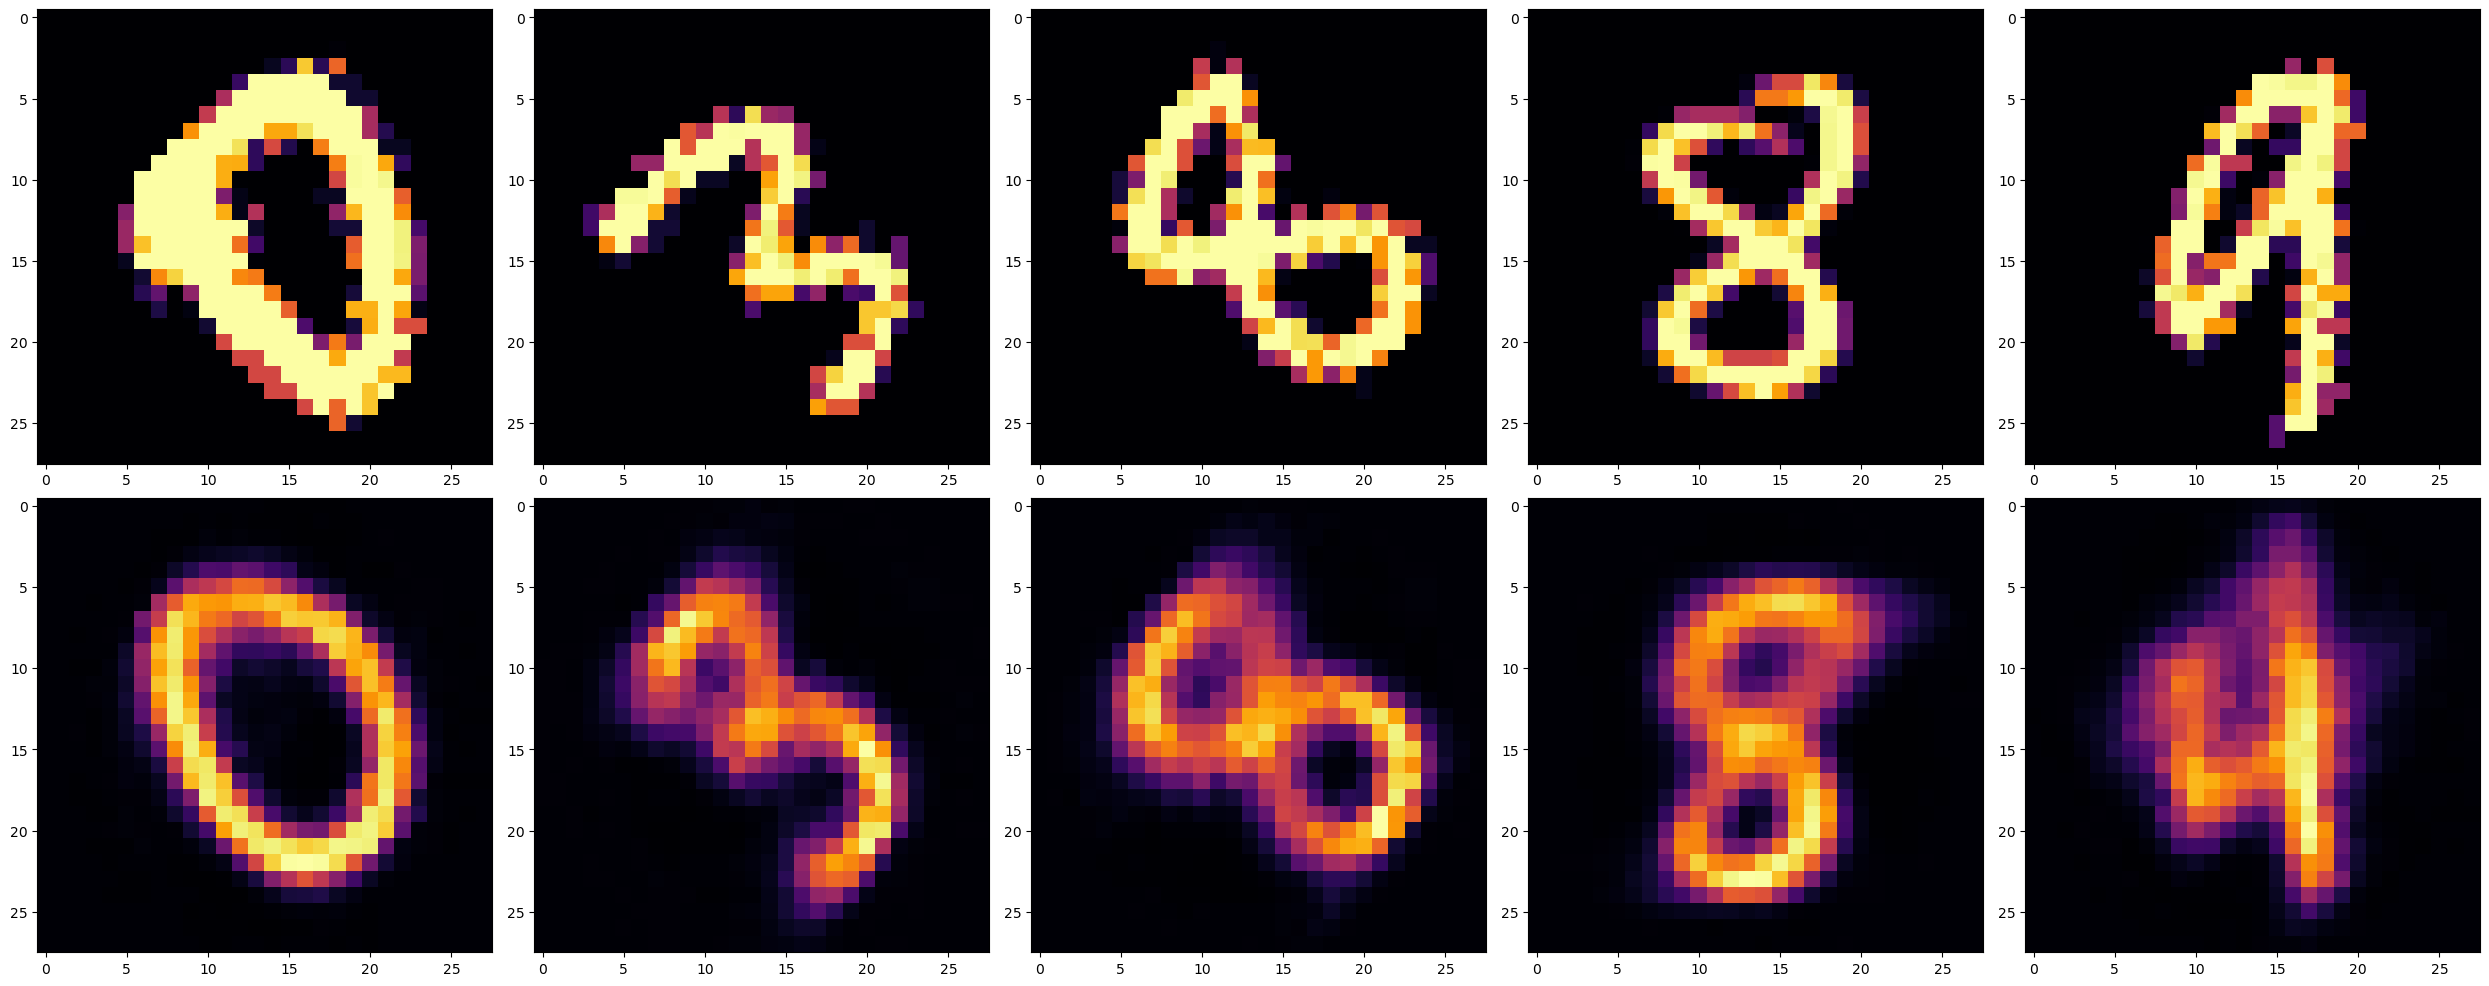

------------------------  ---------
epoch                     100
total loss                178.216
reconstruction error      167.459
KL divergence               5.87501
KL divergence (rotation)    4.88204
------------------------  ---------
347.55 minutes have passed


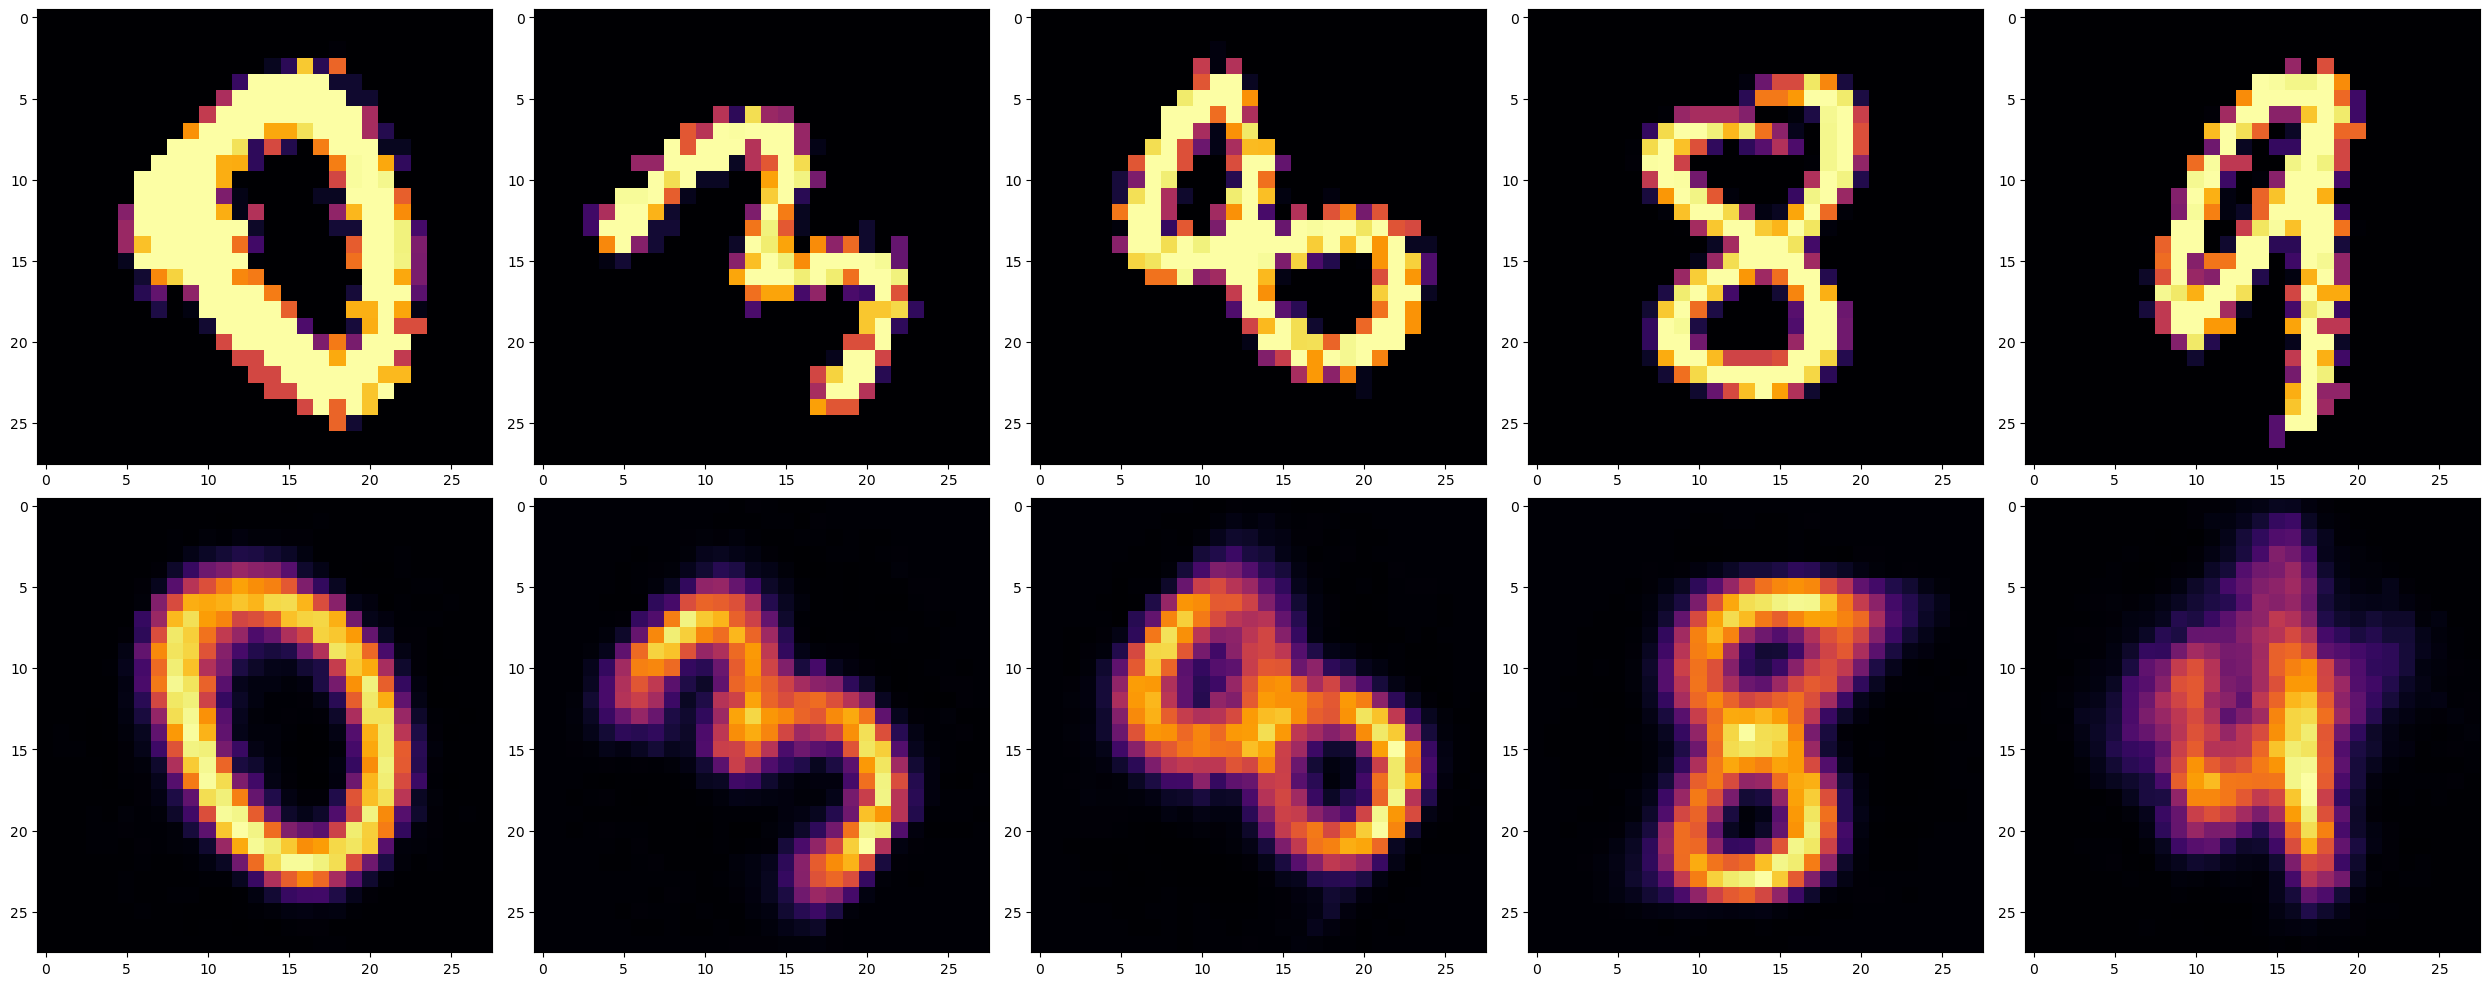

The training has been finished.


In [22]:
start = time.time()
latent_z = []
z_mu = []
z_logvar = []
rot_theta = []
trans_delta = []
n_fig = 5
for epoch in range(n_epoch):
    loss_epoch = 0
    recon_loss = 0
    KLD_loss = 0
    KLD_rot_loss = 0
    for i, m_batch in enumerate(mini_batches):
        
        x = torch.from_numpy(m_batch).clamp_(min=0.01, max=0.99)
        x = x.to(torch.float32)
        x = x.to(cuda_device)
        x.requires_grad_(requires_grad=False)
        
        tf_coord, mu, logvar, z, rot_mu, rot_logvar, rot_z, trans_mu, trans_logvar, trans_z = enc_model(x, coord)
        x_ = dec_model(tf_coord.contiguous(), z)
        #print(x.min(), x.max())
        #print(x_.min(), x_.max())
        
        reconstruction_error = F.binary_cross_entropy(x_.squeeze(), x, reduction="sum")
        KL_divergence = -0.5*torch.sum(1+logvar-mu**2-logvar.exp())
        KL_divergence_rot = torch.sum(-rot_logvar + np.log(angle_std) + (torch.exp(rot_logvar)**2 + 
                                                              rot_mu**2)/2/angle_std**2 - 0.5)
        
        loss = reconstruction_error + KL_divergence + KL_divergence_rot
        #print(reconstruction_error)
        #print(KL_divergence)
        #print(KL_divergence_rot)
        #print(loss)
        
        loss_epoch += loss.item()
        recon_loss += reconstruction_error.item()
        KLD_loss += KL_divergence.item()
        KLD_rot_loss += KL_divergence_rot.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == n_epoch-1:
            latent_z.extend(z.data.cpu().numpy().tolist())
            z_mu.extend(mu.data.cpu().numpy().tolist())
            z_logvar.extend(logvar.data.cpu().numpy().tolist())
            rot_theta.extend(rot_z.data.cpu().numpy().tolist())
            if translation_check:
                trans_delta.extend(trans_z.data.cpu().numpy().tolist())
            
            
    if epoch == 0:
        print(torch.cuda.memory_summary(device=cuda_device))
        
    if (epoch+1) % int(n_epoch/10) == 0:
        print(tabulate([
                        ["epoch", epoch+1], 
                        ["total loss", loss_epoch/total_num],
                        ["reconstruction error", recon_loss/total_num],
                        ["KL divergence", KLD_loss/total_num],
                        ["KL divergence (rotation)", KLD_rot_loss/total_num],
                        ]))
        print("%.2f minutes have passed"%((time.time()-start)/60))
        
        fig, ax = plt.subplots(2, n_fig, figsize=(5*n_fig, 5*2))
        for i in range(n_fig):
            ax[0][i].imshow(x[i].data.cpu().numpy().astype(np.float32), cmap="inferno")
            ax[1][i].imshow(x_[i].squeeze().data.cpu().numpy().astype(np.float32), cmap="inferno")
        fig.tight_layout()
        plt.show()

latent_z = np.asarray(latent_z)
z_mu = np.asarray(z_mu)
z_logvar = np.asarray(z_logvar)
rot_theta = np.asarray(rot_theta)
trans_delta = np.asarray(trans_delta)
print("The training has been finished.")

In [23]:
n_sample = 20
sigma = 3.0
z_test = np.linspace(-sigma, sigma, n_sample*10, endpoint=True)
rv = stats.norm(0, 1)
norm_pdf = rv.pdf(z_test)
norm_pdf = norm_pdf / np.sum(norm_pdf)
z_test = np.sort(np.random.choice(z_test, n_sample, replace=False, p=norm_pdf))
z_test = np.meshgrid(z_test, z_test)
z_test = np.stack((z_test[0].flatten(), z_test[1].flatten()), axis=1)
print(z_test.shape)
z_test = torch.from_numpy(z_test).to(torch.float32).to(cuda_device)

coord_test = img_coord.expand(n_sample**2, img_coord.size(0), img_coord.size(1))
coord_test = coord_test.to(cuda_device)
print(coord_test.shape)

(400, 2)
torch.Size([400, 784, 2])


In [24]:
dec_model.eval()
generated = dec_model(coord_test.contiguous(), z_test)
print(generated.shape)

torch.Size([400, 28, 28])


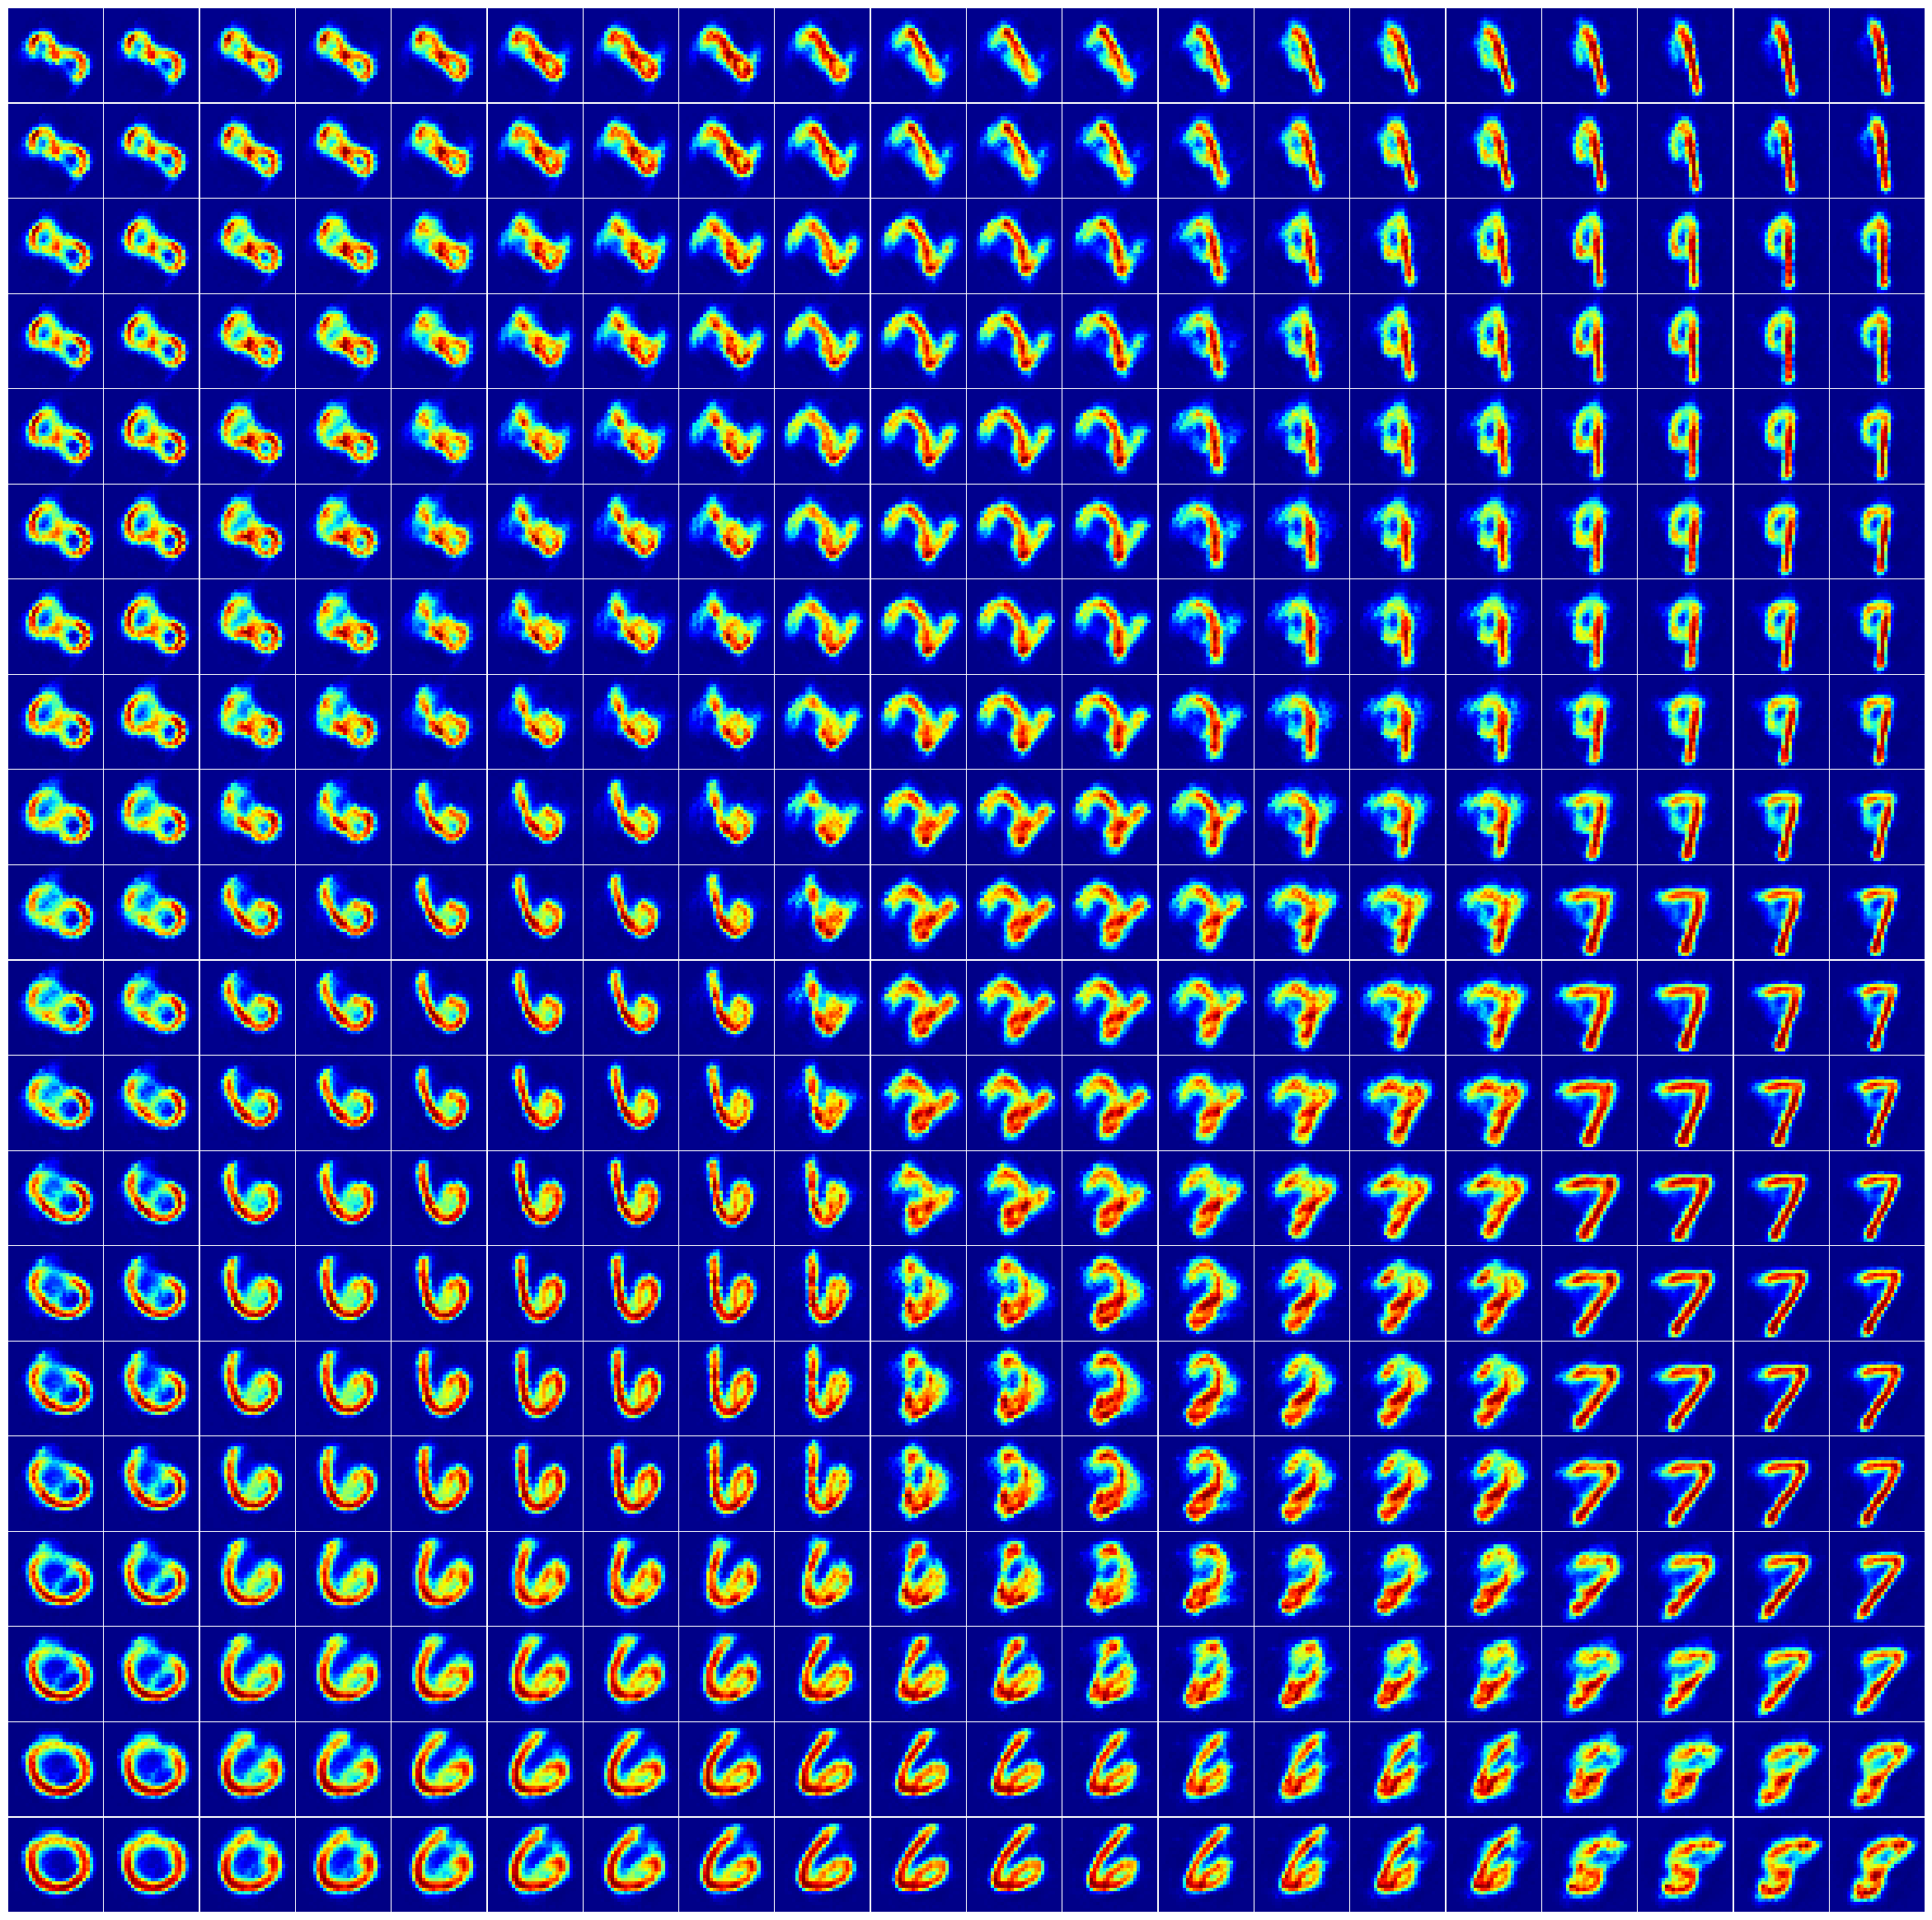

In [25]:
fig, ax = plt.subplots(n_sample, n_sample, figsize=(30, 30))
for i, a in enumerate(ax.flat):
    a.imshow(generated[i].squeeze().data.cpu().numpy().astype(np.float32), cmap="jet")
    a.axis("off")
plt.subplots_adjust(hspace=0.01, wspace=0.01)
plt.show()